# Unsupervised ML on Marina's data.

Should contain ML. Unsupervised and semi-supervised.

1. Test for normality. Log transform and re-test. (R code).  
2. Finish KMeans. DBSCAN - check isotropy requirement. TRY AFTER PCA.  
3. Finish Chi-square
4. Run histograms on the clustered data
5. Run logistic regression on the clustered data.
6. Do GMM  on the transformed data.

Mike Tamir:    
http://www.quora.com/What-is-an-intuitive-explanation-of-the-relation-between-PCA-and-SVD   
http://www.quora.com/When-and-where-do-we-use-SVD/answer/Mike-Tamir   
http://www.quora.com/Mike-Tamir   
http://www.quora.com/Whats-a-good-way-to-provide-intuition-as-to-why-the-lasso-L1-regularization-results-in-sparse-weight-vectors  
http://stats.stackexchange.com/questions/33142/what-happens-when-you-apply-svd-to-a-collaborative-filtering-problem-what-is-th  
http://sifter.org/~simon/journal/20061211.html  
http://www.netflixprize.com/community/viewtopic.php?id=1423  
http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.173.2797&rep=rep1&type=pdf  
http://www.quora.com/What-the-differences-and-similarities-between-LDA-and-k-means-for-topic-detection  



In [1]:
#load necessary libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.mpl_style','default')
%matplotlib inline

%load_ext rmagic

import re
import pygal
from IPython.display import SVG


#convert to eps
#inkscape -z -D F4B_xenopus_laevis_arial.svg --export-eps=F4B_xenopus_laevisCLI_arial.eps
import subprocess as sp
import shlex
import sklearn

In [2]:
import recsys

In [3]:
print recsys.__version__

0.1


##1. Filling in the missing data with SVD. Andrew Ng. Scipy. Python recsys.

## a. Lower rank matrix approximation (Collaborative filtering)

1. Map NaN's

In [4]:
dfo=pd.read_csv('../SEPTEMBER_2014/original.csv')
#this is the cleaned up data frame

In [5]:
#dfo[dfo.organism_CAT==8].organism

In [6]:
#this is the Y matrix
dfo.head()

,time_pf,num_of_cells,meiotic,stage,cell_diameter_um,spindle_length__asters_um,spindle_length_poles_um,spindle_width_um,spindle_aspect_ratio_asters_um,spindle_aspect_ratio_poles_um,...,num_of_cells_CAT,num_of_cells_NUM,classification_CAT,phylum_CAT,organism_CAT,cleavage_type_CAT,fixation_CAT,microscope_CAT,stage_CAT,day_old
0,210,1,0,a,177.82149,41.37903,26.13072,14.45598,2.862416,1.807606,...,1,1,1,1,1,1,1,1,1,131106
1,210,1,0,m,163.05828,24.85329,18.28827,9.97689,2.491086,1.833063,...,1,1,1,1,1,1,1,1,2,131106
2,210,1,0,p,206.00580,35.08890,27.24645,14.63385,2.397790,1.861878,...,1,1,1,1,1,1,1,1,3,131106
3,210,1,0,m,194.04000,42.39774,42.39774,17.46360,2.427778,2.427778,...,1,1,1,1,1,1,1,1,2,131106
4,210,1,0,NaN,180.36018,NaN,NaN,NaN,NaN,NaN,...,1,1,1,1,1,1,1,1,NaN,131106


In [7]:
changed_names=dfo.columns.tolist()

In [8]:
changed_names[changed_names.index('meiotic')]='meiotic_CAT'

In [9]:
changed_names[changed_names.index('centrosome')]='centrosome_CAT'

In [10]:
changed_names[changed_names.index('time_pf')]='time_pf_CAT'

In [11]:
dfo.columns=changed_names

In [12]:
#dfo_info=dfo.info()
type(dfo.info())
#dfo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2001 entries, 0 to 2000
Data columns (total 41 columns):
time_pf_CAT                        2001 non-null int64
num_of_cells                       1914 non-null object
meiotic_CAT                        2001 non-null int64
stage                              1993 non-null object
cell_diameter_um                   1947 non-null float64
spindle_length__asters_um          1899 non-null float64
spindle_length_poles_um            1971 non-null float64
spindle_width_um                   1851 non-null float64
spindle_aspect_ratio_asters_um     1836 non-null float64
spindle_aspect_ratio_poles_um      1836 non-null float64
astere-to-pole_distance_1_um       1834 non-null float64
aster-to-pole_distance_2_um        1788 non-null float64
inner_aster_diameter_1_um          1809 non-null float64
inner_aster_diameter_2_um          1712 non-null float64
outer_aster_diameter_1_um          1664 non-null float64
outer__diameter_2_um               1582 non-

NoneType

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11041d290>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1129ed090>]], dtype=object)

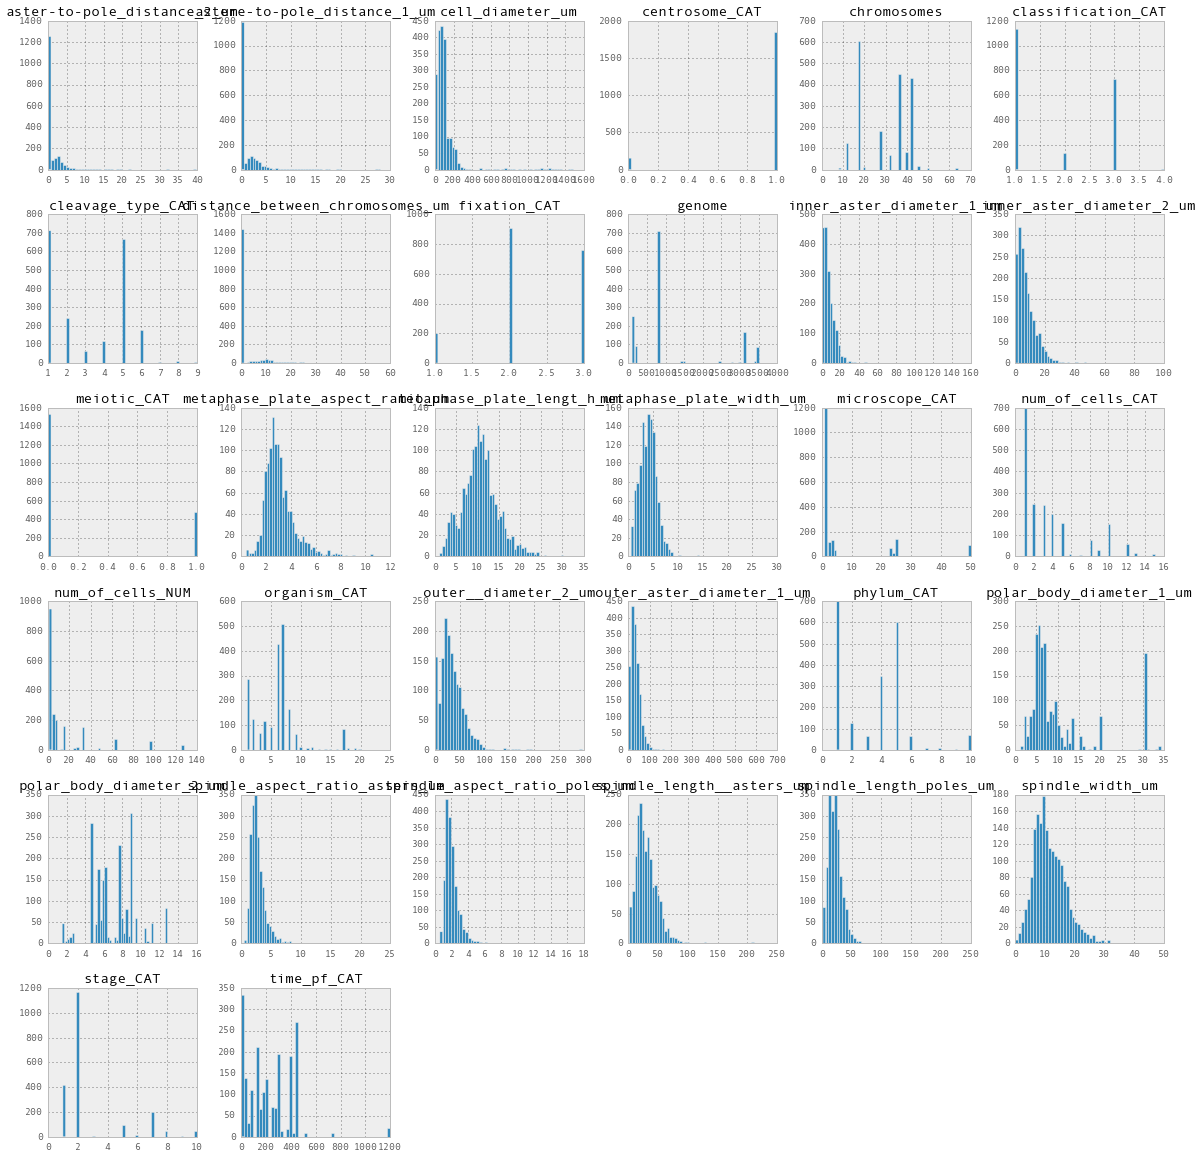

In [13]:
dfo.hist(bins=50, figsize=(20,20))

In [14]:
#dfo is a ndarray
#get only dtype=object columns 
#dfo.dtypes #series
dfo.dtypes[dfo.dtypes == 'object'].index #columns with dtype 'object'


Index([u'num_of_cells', u'stage', u'microscope', u'fixation', u'organism', u'phylum', u'classification', u'cleavage_type', u'day_old'], dtype='object')

In [15]:
#type(dfo.dtypes[dfo.dtypes == 'object'].index)
cols_to_delete=dfo.dtypes[dfo.dtypes == 'object'].index

In [16]:
cols_to_delete=cols_to_delete.tolist()

In [17]:
#dfo.drop(cols_to_delete,axis=1).info()
dfo=dfo.drop(cols_to_delete,axis=1)

In [18]:
dfo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2001 entries, 0 to 2000
Data columns (total 32 columns):
time_pf_CAT                        2001 non-null int64
meiotic_CAT                        2001 non-null int64
cell_diameter_um                   1947 non-null float64
spindle_length__asters_um          1899 non-null float64
spindle_length_poles_um            1971 non-null float64
spindle_width_um                   1851 non-null float64
spindle_aspect_ratio_asters_um     1836 non-null float64
spindle_aspect_ratio_poles_um      1836 non-null float64
astere-to-pole_distance_1_um       1834 non-null float64
aster-to-pole_distance_2_um        1788 non-null float64
inner_aster_diameter_1_um          1809 non-null float64
inner_aster_diameter_2_um          1712 non-null float64
outer_aster_diameter_1_um          1664 non-null float64
outer__diameter_2_um               1582 non-null float64
centrosome_CAT                     2001 non-null int64
metaphase_plate_lengt_h_um         1685 non-

In [19]:
#keep int64 for now
#dfo.dtypes[dfo.dtypes=='int64'].index.tolist()

***TEST APPROACH***

In [20]:
test=dfo[dfo.dtypes[dfo.dtypes=='int64'].index.tolist()]

In [21]:
test.dtypes

time_pf_CAT           int64
meiotic_CAT           int64
centrosome_CAT        int64
classification_CAT    int64
phylum_CAT            int64
organism_CAT          int64
cleavage_type_CAT     int64
dtype: object

In [22]:
test[test.columns]=test[test.columns].astype(float)

/usr/local/lib/python2.7/site-packages/pandas/core/frame.py:2131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [23]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2001 entries, 0 to 2000
Data columns (total 7 columns):
time_pf_CAT           2001 non-null float64
meiotic_CAT           2001 non-null float64
centrosome_CAT        2001 non-null float64
classification_CAT    2001 non-null float64
phylum_CAT            2001 non-null float64
organism_CAT          2001 non-null float64
cleavage_type_CAT     2001 non-null float64
dtypes: float64(7)
memory usage: 125.1 KB


***END: TEST APPROACH***

In [24]:
dfo.head()

,time_pf_CAT,meiotic_CAT,cell_diameter_um,spindle_length__asters_um,spindle_length_poles_um,spindle_width_um,spindle_aspect_ratio_asters_um,spindle_aspect_ratio_poles_um,astere-to-pole_distance_1_um,aster-to-pole_distance_2_um,...,chromosomes,num_of_cells_CAT,num_of_cells_NUM,classification_CAT,phylum_CAT,organism_CAT,cleavage_type_CAT,fixation_CAT,microscope_CAT,stage_CAT
0,210,0,177.82149,41.37903,26.13072,14.45598,2.862416,1.807606,2.5872,2.9106,...,36,1,1,1,1,1,1,1,1,1
1,210,0,163.05828,24.85329,18.28827,9.97689,2.491086,1.833063,0.0000,0.0000,...,36,1,1,1,1,1,1,1,1,2
2,210,0,206.00580,35.08890,27.24645,14.63385,2.397790,1.861878,0.0000,0.0000,...,36,1,1,1,1,1,1,1,1,3
3,210,0,194.04000,42.39774,42.39774,17.46360,2.427778,2.427778,0.0000,0.0000,...,36,1,1,1,1,1,1,1,1,2
4,210,0,180.36018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,36,1,1,1,1,1,1,1,1,NaN


In [25]:
dfo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2001 entries, 0 to 2000
Data columns (total 32 columns):
time_pf_CAT                        2001 non-null int64
meiotic_CAT                        2001 non-null int64
cell_diameter_um                   1947 non-null float64
spindle_length__asters_um          1899 non-null float64
spindle_length_poles_um            1971 non-null float64
spindle_width_um                   1851 non-null float64
spindle_aspect_ratio_asters_um     1836 non-null float64
spindle_aspect_ratio_poles_um      1836 non-null float64
astere-to-pole_distance_1_um       1834 non-null float64
aster-to-pole_distance_2_um        1788 non-null float64
inner_aster_diameter_1_um          1809 non-null float64
inner_aster_diameter_2_um          1712 non-null float64
outer_aster_diameter_1_um          1664 non-null float64
outer__diameter_2_um               1582 non-null float64
centrosome_CAT                     2001 non-null int64
metaphase_plate_lengt_h_um         1685 non-

**There should be no missing values in the int64 variables.**

In [26]:
dfo[dfo.dtypes[dfo.dtypes=='int64'].index].isnull().describe()#.time_pf.value_counts()

,time_pf_CAT,meiotic_CAT,centrosome_CAT,classification_CAT,phylum_CAT,organism_CAT,cleavage_type_CAT
count,2001,2001,2001,2001,2001,2001,2001
mean,0,0,0,0,0,0,0
std,0,0,0,0,0,0,0
min,False,False,False,False,False,False,False
25%,0,0,0,0,0,0,0
50%,0,0,0,0,0,0,0
75%,0,0,0,0,0,0,0
max,False,False,False,False,False,False,False


In [27]:
for col in dfo[dfo.dtypes[dfo.dtypes=='int64'].index].isnull():
    print col
    print dfo[dfo.dtypes[dfo.dtypes=='int64'].index].isnull()[col].value_counts()
    print

time_pf_CAT
False    2001
dtype: int64

meiotic_CAT
False    2001
dtype: int64

centrosome_CAT
False    2001
dtype: int64

classification_CAT
False    2001
dtype: int64

phylum_CAT
False    2001
dtype: int64

organism_CAT
False    2001
dtype: int64

cleavage_type_CAT
False    2001
dtype: int64



**SUMMARY: There are no missing values in the int64 variables.**

In [28]:
dfo.get_values().shape

(2001, 32)

In [29]:
#dfo.max()
dfo[dfo.inner_aster_diameter_2_um==dfo.inner_aster_diameter_2_um.max()].inner_aster_diameter_2_um

1324    95.7
Name: inner_aster_diameter_2_um, dtype: float64

In [30]:
dfo.max()

time_pf_CAT                        1200.000000
meiotic_CAT                           1.000000
cell_diameter_um                   1486.643200
spindle_length__asters_um           210.371700
spindle_length_poles_um             231.000000
spindle_width_um                     49.771260
spindle_aspect_ratio_asters_um       21.111111
spindle_aspect_ratio_poles_um        17.500000
astere-to-pole_distance_1_um         28.000000
aster-to-pole_distance_2_um          39.800000
inner_aster_diameter_1_um           142.000000
inner_aster_diameter_2_um            95.700000
outer_aster_diameter_1_um           606.160400
outer__diameter_2_um                296.700000
centrosome_CAT                        1.000000
metaphase_plate_lengt_h_um           30.200000
metaphase_plate_width_um             26.987730
metaphase_plate_aspect_ratio_um      10.583333
polar_body_diameter_1_um             34.200000
polar_body_diameter_2_um             14.100240
distance_between_chromosomes_um      52.698030
genome       

In [31]:
dfo.min()

time_pf_CAT                          0.000000
meiotic_CAT                          0.000000
cell_diameter_um                     0.100000
spindle_length__asters_um            2.005080
spindle_length_poles_um              2.005080
spindle_width_um                     0.000000
spindle_aspect_ratio_asters_um       0.478892
spindle_aspect_ratio_poles_um        0.601124
astere-to-pole_distance_1_um         0.000000
aster-to-pole_distance_2_um          0.000000
inner_aster_diameter_1_um            0.000000
inner_aster_diameter_2_um            0.000000
outer_aster_diameter_1_um            0.000000
outer__diameter_2_um                 0.000000
centrosome_CAT                       0.000000
metaphase_plate_lengt_h_um           1.146600
metaphase_plate_width_um             0.565950
metaphase_plate_aspect_ratio_um      0.393885
polar_body_diameter_1_um             1.293600
polar_body_diameter_2_um             1.519980
distance_between_chromosomes_um      0.000000
genome                            

In [32]:
#dfo[dfo.organism_CAT==8].inner_aster_diameter_2_um.tolist()

In [33]:
#line 35 of ex8_cofi.m
#returns Y where R cell = 1 (True)


In [34]:
dfo.head()

,time_pf_CAT,meiotic_CAT,cell_diameter_um,spindle_length__asters_um,spindle_length_poles_um,spindle_width_um,spindle_aspect_ratio_asters_um,spindle_aspect_ratio_poles_um,astere-to-pole_distance_1_um,aster-to-pole_distance_2_um,...,chromosomes,num_of_cells_CAT,num_of_cells_NUM,classification_CAT,phylum_CAT,organism_CAT,cleavage_type_CAT,fixation_CAT,microscope_CAT,stage_CAT
0,210,0,177.82149,41.37903,26.13072,14.45598,2.862416,1.807606,2.5872,2.9106,...,36,1,1,1,1,1,1,1,1,1
1,210,0,163.05828,24.85329,18.28827,9.97689,2.491086,1.833063,0.0000,0.0000,...,36,1,1,1,1,1,1,1,1,2
2,210,0,206.00580,35.08890,27.24645,14.63385,2.397790,1.861878,0.0000,0.0000,...,36,1,1,1,1,1,1,1,1,3
3,210,0,194.04000,42.39774,42.39774,17.46360,2.427778,2.427778,0.0000,0.0000,...,36,1,1,1,1,1,1,1,1,2
4,210,0,180.36018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,36,1,1,1,1,1,1,1,1,NaN


In [35]:
#to create the R matrix
dfo_map=dfo.copy()

In [36]:
dfo_map.head()

,time_pf_CAT,meiotic_CAT,cell_diameter_um,spindle_length__asters_um,spindle_length_poles_um,spindle_width_um,spindle_aspect_ratio_asters_um,spindle_aspect_ratio_poles_um,astere-to-pole_distance_1_um,aster-to-pole_distance_2_um,...,chromosomes,num_of_cells_CAT,num_of_cells_NUM,classification_CAT,phylum_CAT,organism_CAT,cleavage_type_CAT,fixation_CAT,microscope_CAT,stage_CAT
0,210,0,177.82149,41.37903,26.13072,14.45598,2.862416,1.807606,2.5872,2.9106,...,36,1,1,1,1,1,1,1,1,1
1,210,0,163.05828,24.85329,18.28827,9.97689,2.491086,1.833063,0.0000,0.0000,...,36,1,1,1,1,1,1,1,1,2
2,210,0,206.00580,35.08890,27.24645,14.63385,2.397790,1.861878,0.0000,0.0000,...,36,1,1,1,1,1,1,1,1,3
3,210,0,194.04000,42.39774,42.39774,17.46360,2.427778,2.427778,0.0000,0.0000,...,36,1,1,1,1,1,1,1,1,2
4,210,0,180.36018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,36,1,1,1,1,1,1,1,1,NaN


In [37]:
dfo.get_values()

array([[ 210.     ,    0.     ,  177.82149, ...,    1.     ,    1.     ,
           1.     ],
       [ 210.     ,    0.     ,  163.05828, ...,    1.     ,    1.     ,
           2.     ],
       [ 210.     ,    0.     ,  206.0058 , ...,    1.     ,    1.     ,
           3.     ],
       ..., 
       [ 130.     ,    0.     ,   71.8    , ...,        nan,        nan,
           2.     ],
       [ 130.     ,    0.     ,   71.8    , ...,        nan,        nan,
           2.     ],
       [ 130.     ,    0.     ,   73.5    , ...,        nan,        nan,
           2.     ]])

### Visualize data matrix before normalization. 

The white spots are missing values.

In [38]:
#plt.imshow(dfo.get_values())

<matplotlib.colorbar.Colorbar instance at 0x113d3e680>

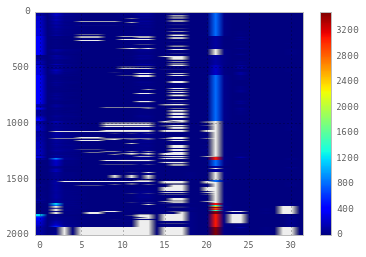

In [39]:
#BEFORE VALUE SCALING AND NORMALIZING6
#http://mathesaurus.sourceforge.net/matlab-numpy.html
#http://matplotlib.org/users/image_tutorial.html

#http://stackoverflow.com/questions/6999621/how-to-use-extent-in-matplotlib-pyplot-imshow
#plt.figure(figsize=(50,5))
#http://stackoverflow.com/questions/6999621/how-to-use-extent-in-matplotlib-pyplot-imshow


plt.imshow(dfo.get_values(),aspect='auto')
plt.colorbar()
#plt.savefig('NAs_matrix.pdf')

In [40]:
#http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.xlabel
def visualizeDataFrame(data_frame, row_names='Examples', column_names='Variables',title=''):
    plt.imshow(data_frame.get_values(),aspect='auto')
    plt.xlabel(row_names, verticalalignment ='top')
    plt.ylabel(column_names)
    plt.title(title)
    plt.colorbar()

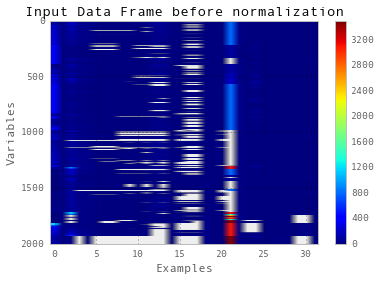

In [41]:
visualizeDataFrame(dfo,title='Input Data Frame before normalization')

#### CONDITIONAL SUBSETTING: line 35 in ex8_cofi.m - for creating R matrix

In [42]:
dfo_map=dfo_map.isnull()

In [43]:
#this is the R matrix
dfo_map.head()

,time_pf_CAT,meiotic_CAT,cell_diameter_um,spindle_length__asters_um,spindle_length_poles_um,spindle_width_um,spindle_aspect_ratio_asters_um,spindle_aspect_ratio_poles_um,astere-to-pole_distance_1_um,aster-to-pole_distance_2_um,...,chromosomes,num_of_cells_CAT,num_of_cells_NUM,classification_CAT,phylum_CAT,organism_CAT,cleavage_type_CAT,fixation_CAT,microscope_CAT,stage_CAT
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,True


In [44]:
R = np.where(dfo_map == True, 0, 1)

In [45]:
R

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ..., 
       [1, 1, 1, ..., 0, 0, 1],
       [1, 1, 1, ..., 0, 0, 1],
       [1, 1, 1, ..., 0, 0, 1]])

In [46]:
dfo.loc[4,:]

time_pf_CAT                        210.00000
meiotic_CAT                          0.00000
cell_diameter_um                   180.36018
spindle_length__asters_um                NaN
spindle_length_poles_um                  NaN
spindle_width_um                         NaN
spindle_aspect_ratio_asters_um           NaN
spindle_aspect_ratio_poles_um            NaN
astere-to-pole_distance_1_um             NaN
aster-to-pole_distance_2_um              NaN
inner_aster_diameter_1_um                NaN
inner_aster_diameter_2_um                NaN
outer_aster_diameter_1_um                NaN
outer__diameter_2_um                     NaN
centrosome_CAT                       1.00000
metaphase_plate_lengt_h_um               NaN
metaphase_plate_width_um                 NaN
metaphase_plate_aspect_ratio_um          NaN
polar_body_diameter_1_um            10.33263
polar_body_diameter_2_um            10.78539
distance_between_chromosomes_um          NaN
genome                             811.00000
chromosome

In [47]:
dfo_map.loc[4,:]

time_pf_CAT                        False
meiotic_CAT                        False
cell_diameter_um                   False
spindle_length__asters_um           True
spindle_length_poles_um             True
spindle_width_um                    True
spindle_aspect_ratio_asters_um      True
spindle_aspect_ratio_poles_um       True
astere-to-pole_distance_1_um        True
aster-to-pole_distance_2_um         True
inner_aster_diameter_1_um           True
inner_aster_diameter_2_um           True
outer_aster_diameter_1_um           True
outer__diameter_2_um                True
centrosome_CAT                     False
metaphase_plate_lengt_h_um          True
metaphase_plate_width_um            True
metaphase_plate_aspect_ratio_um     True
polar_body_diameter_1_um           False
polar_body_diameter_2_um           False
distance_between_chromosomes_um     True
genome                             False
chromosomes                        False
num_of_cells_CAT                   False
num_of_cells_NUM

In [48]:
#conditional subsetting
dfo.loc[4,:][dfo_map.loc[4,:]==True]

spindle_length__asters_um         NaN
spindle_length_poles_um           NaN
spindle_width_um                  NaN
spindle_aspect_ratio_asters_um    NaN
spindle_aspect_ratio_poles_um     NaN
astere-to-pole_distance_1_um      NaN
aster-to-pole_distance_2_um       NaN
inner_aster_diameter_1_um         NaN
inner_aster_diameter_2_um         NaN
outer_aster_diameter_1_um         NaN
outer__diameter_2_um              NaN
metaphase_plate_lengt_h_um        NaN
metaphase_plate_width_um          NaN
metaphase_plate_aspect_ratio_um   NaN
distance_between_chromosomes_um   NaN
stage_CAT                         NaN
Name: 4, dtype: float64

In [49]:
dfo.loc[4,:][dfo_map.loc[4,:]==False].mean()

79.217387500000001

### COLLABORATIVE FILTERING: LOW RANK MATRIX APPROXIMATION

In [50]:
dfo.shape, dfo_map.shape

((2001, 32), (2001, 32))

In [51]:
#params - column vector with concatanated, unravelled X and Theta matrices

#Y
#R
#num_users = dfo_map.shape[1] #number of columns /variables
#num_movies = dfo_map.shape[0]#number of rows/examples
#num_features: aribtrary: try 100

In [52]:
#http://docs.scipy.org/doc/numpy/reference/generated/numpy.ravel.html
#http://docs.scipy.org/doc/numpy/reference/generated/numpy.hstack.html
#http://stackoverflow.com/questions/3394835/args-and-kwargs
#http://stackoverflow.com/questions/36901/what-does-double-star-and-star-do-for-python-parameters
#https://docs.python.org/dev/tutorial/controlflow.html#more-on-defining-functions
#HELPER 1

def serialize(*args):
    return np.hstack(a.ravel('F') for a in args)

#### test np.ravel 'orders'

In [53]:
#?np.array

In [54]:
a=np.array([ [1,2,3],[4,5,6],[7,8,9] ])

In [55]:
a

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [56]:
a.ravel('C')

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [57]:
a.ravel('F')

array([1, 4, 7, 2, 5, 8, 3, 6, 9])

**END: test**

#### test np.hstack 

In [58]:
np.hstack((a.ravel('C'),a.ravel('F')))

array([1, 2, 3, 4, 5, 6, 7, 8, 9, 1, 4, 7, 2, 5, 8, 3, 6, 9])

**END: test**

In [59]:
dfo.loc[4,:][dfo_map.loc[4,:]==False].mean()

79.217387500000001

In [60]:
#how many NaN's in each column
for col in dfo.columns:
    print len(dfo[dfo[col].isnull()==False])
    #print np.mean(dfo[col][dfo_map[col]==False])
    #print len(dfo[dfo[col].isnull()==True])
    #print dfo[col][dfo[col].isnull()==True]

2001
2001
1947
1899
1971
1851
1836
1836
1834
1788
1809
1712
1664
1582
2001
1685
1212
1201
1999
1997
1886
1358
1997
1914
1914
2001
2001
2001
2001
1863
1863
1993


In [61]:
#np.subtract(dfo,np.ones((1,dfo.shape[1])))


### FEATURE SCALING 

In [62]:
#this is a value to keep
initial_means=dfo.mean(axis=0)

In [63]:
initial_means

time_pf_CAT                         220.012994
meiotic_CAT                           0.236382
cell_diameter_um                    108.800352
spindle_length__asters_um            30.644614
spindle_length_poles_um              22.373868
spindle_width_um                     11.518706
spindle_aspect_ratio_asters_um        2.700673
spindle_aspect_ratio_poles_um         2.040230
astere-to-pole_distance_1_um          1.231875
aster-to-pole_distance_2_um           1.144923
inner_aster_diameter_1_um             7.536544
inner_aster_diameter_2_um             7.514501
outer_aster_diameter_1_um            33.383070
outer__diameter_2_um                 33.495913
centrosome_CAT                        0.923038
metaphase_plate_lengt_h_um           10.618968
metaphase_plate_width_um              3.993019
metaphase_plate_aspect_ratio_um       3.053011
polar_body_diameter_1_um              9.945500
polar_body_diameter_2_um              7.043778
distance_between_chromosomes_um       3.342549
genome       

In [64]:
initial_std=dfo.std(axis=0)

In [65]:
initial_std

time_pf_CAT                         186.964737
meiotic_CAT                           0.424966
cell_diameter_um                    157.838006
spindle_length__asters_um            18.152905
spindle_length_poles_um              12.011064
spindle_width_um                      5.403774
spindle_aspect_ratio_asters_um        1.339841
spindle_aspect_ratio_poles_um         0.962627
astere-to-pole_distance_1_um          2.457425
aster-to-pole_distance_2_um           2.643949
inner_aster_diameter_1_um             7.610364
inner_aster_diameter_2_um             6.839366
outer_aster_diameter_1_um            30.094927
outer__diameter_2_um                 24.792013
centrosome_CAT                        0.266597
metaphase_plate_lengt_h_um            4.126341
metaphase_plate_width_um              1.901752
metaphase_plate_aspect_ratio_um       1.206626
polar_body_diameter_1_um              8.075802
polar_body_diameter_2_um              2.345080
distance_between_chromosomes_um       7.528474
genome       

In [66]:
dfo_scaled=dfo.subtract(dfo.mean(axis=0),axis=1)

In [67]:
dfo.head()

,time_pf_CAT,meiotic_CAT,cell_diameter_um,spindle_length__asters_um,spindle_length_poles_um,spindle_width_um,spindle_aspect_ratio_asters_um,spindle_aspect_ratio_poles_um,astere-to-pole_distance_1_um,aster-to-pole_distance_2_um,...,chromosomes,num_of_cells_CAT,num_of_cells_NUM,classification_CAT,phylum_CAT,organism_CAT,cleavage_type_CAT,fixation_CAT,microscope_CAT,stage_CAT
0,210,0,177.82149,41.37903,26.13072,14.45598,2.862416,1.807606,2.5872,2.9106,...,36,1,1,1,1,1,1,1,1,1
1,210,0,163.05828,24.85329,18.28827,9.97689,2.491086,1.833063,0.0000,0.0000,...,36,1,1,1,1,1,1,1,1,2
2,210,0,206.00580,35.08890,27.24645,14.63385,2.397790,1.861878,0.0000,0.0000,...,36,1,1,1,1,1,1,1,1,3
3,210,0,194.04000,42.39774,42.39774,17.46360,2.427778,2.427778,0.0000,0.0000,...,36,1,1,1,1,1,1,1,1,2
4,210,0,180.36018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,36,1,1,1,1,1,1,1,1,NaN


In [68]:
dfo_scaled.head()

,time_pf_CAT,meiotic_CAT,cell_diameter_um,spindle_length__asters_um,spindle_length_poles_um,spindle_width_um,spindle_aspect_ratio_asters_um,spindle_aspect_ratio_poles_um,astere-to-pole_distance_1_um,aster-to-pole_distance_2_um,...,chromosomes,num_of_cells_CAT,num_of_cells_NUM,classification_CAT,phylum_CAT,organism_CAT,cleavage_type_CAT,fixation_CAT,microscope_CAT,stage_CAT
0,-10.012994,-0.236382,69.021138,10.734416,3.756852,2.937274,0.161743,-0.232623,1.355325,1.765677,...,6.29344,-2.748171,-13.229885,-0.804598,-2.413293,-5.022489,-2.205897,-1.30059,-6.286098,-1.809834
1,-10.012994,-0.236382,54.257928,-5.791324,-4.085598,-1.541816,-0.209588,-0.207166,-1.231875,-1.144923,...,6.29344,-2.748171,-13.229885,-0.804598,-2.413293,-5.022489,-2.205897,-1.30059,-6.286098,-0.809834
2,-10.012994,-0.236382,97.205448,4.444286,4.872582,3.115144,-0.302883,-0.178351,-1.231875,-1.144923,...,6.29344,-2.748171,-13.229885,-0.804598,-2.413293,-5.022489,-2.205897,-1.30059,-6.286098,0.190166
3,-10.012994,-0.236382,85.239648,11.753126,20.023872,5.944894,-0.272896,0.387548,-1.231875,-1.144923,...,6.29344,-2.748171,-13.229885,-0.804598,-2.413293,-5.022489,-2.205897,-1.30059,-6.286098,-0.809834
4,-10.012994,-0.236382,71.559828,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.29344,-2.748171,-13.229885,-0.804598,-2.413293,-5.022489,-2.205897,-1.30059,-6.286098,NaN


In [69]:
dfo_normalized=dfo_scaled.divide(initial_std,axis=1)

In [70]:
dfo_normalized.head()

,time_pf_CAT,meiotic_CAT,cell_diameter_um,spindle_length__asters_um,spindle_length_poles_um,spindle_width_um,spindle_aspect_ratio_asters_um,spindle_aspect_ratio_poles_um,astere-to-pole_distance_1_um,aster-to-pole_distance_2_um,...,chromosomes,num_of_cells_CAT,num_of_cells_NUM,classification_CAT,phylum_CAT,organism_CAT,cleavage_type_CAT,fixation_CAT,microscope_CAT,stage_CAT
0,-0.053556,-0.556238,0.437291,0.591333,0.312783,0.543560,0.120718,-0.241655,0.551522,0.667818,...,0.576924,-0.813297,-0.518265,-0.847039,-1.082553,-1.356934,-1.112928,-2.002214,-0.48226,-0.805233
1,-0.053556,-0.556238,0.343757,-0.319030,-0.340153,-0.285322,-0.156427,-0.215209,-0.501287,-0.433035,...,0.576924,-0.813297,-0.518265,-0.847039,-1.082553,-1.356934,-1.112928,-2.002214,-0.48226,-0.360312
2,-0.053556,-0.556238,0.615856,0.244825,0.405674,0.576476,-0.226059,-0.185275,-0.501287,-0.433035,...,0.576924,-0.813297,-0.518265,-0.847039,-1.082553,-1.356934,-1.112928,-2.002214,-0.48226,0.084609
3,-0.053556,-0.556238,0.540045,0.647452,1.667119,1.100137,-0.203678,0.402594,-0.501287,-0.433035,...,0.576924,-0.813297,-0.518265,-0.847039,-1.082553,-1.356934,-1.112928,-2.002214,-0.48226,-0.360312
4,-0.053556,-0.556238,0.453375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.576924,-0.813297,-0.518265,-0.847039,-1.082553,-1.356934,-1.112928,-2.002214,-0.48226,NaN


In [71]:
#HELPER 2
#modified versions of normalizeRatings.py

def normalizeRatings_row(Y, R):
    '''Y and R are data frames
    
    NORMALIZERATINGS Preprocess data by subtracting mean rating for every
    movie (every row) and divide by standard deviation for every row (movie)
       Ynorm, Ymean, Ystd = NORMALIZERATINGS(Y, R) normalized Y so that each movie
       has a rating of 0 on average, and returns the mean rating in Ymean, and std in Ystd.
    '''

    m, n = np.shape(Y)
    Ymean = np.zeros(m)
    Ystd=np.zeros(m)
    Ynorm = np.zeros(np.shape(Y))
    for i in range(m):
        idx = np.where(R.iloc[i, :] == False)
        Ymean[i] = np.mean(Y.iloc[i, idx])
        Ystd[i]=np.std(Y.iloc[i,idx])
        Ynorm[i, idx] = (Y.iloc[i, idx] - Ymean[i])/Ystd[i]

    return Ynorm, Ymean, Ystd

def normalizeRatings_column(Y, R):
    '''Y and R are data frames
    
    NORMALIZERATINGS Preprocess data by subtracting mean rating for every
    movie (every column)
       Ynorm, Ymean = NORMALIZERATINGS(Y, R) normalized Y so that each user rating 
       has a rating of 0 on average (across all movies), and returns the mean rating in Ymean, and std in Ystd.
    '''

    m, n = np.shape(Y)
    Ymean = np.zeros(n)
    Ystd=np.zeros(n)
    Ynorm = np.zeros(np.shape(Y))
    for i in range(n): #1 to 32
        idx = np.where(R.iloc[:,i]==False)[0]

        Ymean[i] = np.mean(Y.iloc[idx, i])
        Ystd[i]=np.std(Y.iloc[idx,i])
        Ynorm[idx, i] = (Y.iloc[idx, i] - Ymean[i])/Ystd[i]

    return Ynorm, Ymean, Ystd

In [72]:
#HELPER 2
#import pandas as pd
def normalizeDataFrame(data_frame):
    '''scales feature data frame; takes pandas data frame as input; 
    returns scaled data frame, vector of means for all variables, 
    vector of standard variations for all variables, 
    '''
    
    dfo_col_mean_vector=data_frame.mean(axis=0)
    dfo_centered=data_frame.subtract(dfo_col_mean_vector,axis=1)
    
    dfo_col_std_vector=data_frame.std(axis=0)
    dfo_normalized=dfo_centered.divide(initial_std,axis=1)
    
    return dfo_normalized, dfo_col_mean_vector, dfo_col_std_vector


In [73]:
#normalizeDataFrame(dfo)
dfo_normalized.head()



,time_pf_CAT,meiotic_CAT,cell_diameter_um,spindle_length__asters_um,spindle_length_poles_um,spindle_width_um,spindle_aspect_ratio_asters_um,spindle_aspect_ratio_poles_um,astere-to-pole_distance_1_um,aster-to-pole_distance_2_um,...,chromosomes,num_of_cells_CAT,num_of_cells_NUM,classification_CAT,phylum_CAT,organism_CAT,cleavage_type_CAT,fixation_CAT,microscope_CAT,stage_CAT
0,-0.053556,-0.556238,0.437291,0.591333,0.312783,0.543560,0.120718,-0.241655,0.551522,0.667818,...,0.576924,-0.813297,-0.518265,-0.847039,-1.082553,-1.356934,-1.112928,-2.002214,-0.48226,-0.805233
1,-0.053556,-0.556238,0.343757,-0.319030,-0.340153,-0.285322,-0.156427,-0.215209,-0.501287,-0.433035,...,0.576924,-0.813297,-0.518265,-0.847039,-1.082553,-1.356934,-1.112928,-2.002214,-0.48226,-0.360312
2,-0.053556,-0.556238,0.615856,0.244825,0.405674,0.576476,-0.226059,-0.185275,-0.501287,-0.433035,...,0.576924,-0.813297,-0.518265,-0.847039,-1.082553,-1.356934,-1.112928,-2.002214,-0.48226,0.084609
3,-0.053556,-0.556238,0.540045,0.647452,1.667119,1.100137,-0.203678,0.402594,-0.501287,-0.433035,...,0.576924,-0.813297,-0.518265,-0.847039,-1.082553,-1.356934,-1.112928,-2.002214,-0.48226,-0.360312
4,-0.053556,-0.556238,0.453375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.576924,-0.813297,-0.518265,-0.847039,-1.082553,-1.356934,-1.112928,-2.002214,-0.48226,NaN


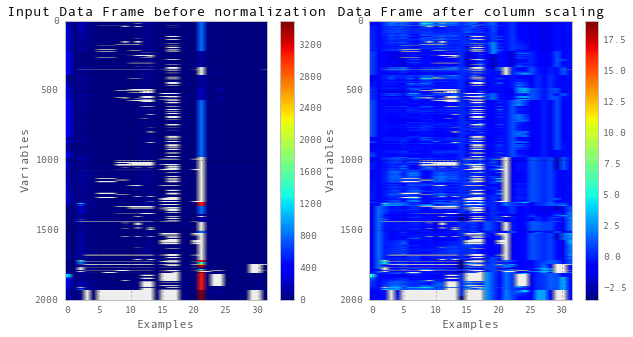

In [74]:
plt.figure(figsize=(10,5))
plt.subplot(121)
visualizeDataFrame(dfo,title='Input Data Frame before normalization')
plt.subplot(122)
visualizeDataFrame(dfo_normalized, title='Data Frame after column scaling')

In [75]:
#scipy.optimize.fmin_cg

#http://en.wikipedia.org/wiki/Low-rank_approximation

In [76]:
#HELPER 3
#after cofiCostFunc.m
def cofiCostFunc(params, Y, R, num_users, num_movies, num_features, lambda_):
    '''COFICOSTFUNC Collaborative filtering cost function
        J, grad = COFICOSTFUNC(params, Y, R, num_users, num_movies, num_features, lambda_)
        returns the cost and gradient for the collaborative filtering problem.
    

        Unfold the U and W matrices from params
        params is a result from: np.hstack((X.ravel('F'), Theta.ravel('F')))
    '''
    X = np.reshape(params[:num_movies*num_features], (num_movies, num_features), order='F')
    Theta = np.reshape(params[num_movies*num_features:], (num_users, num_features), order='F')


    
    J = 0
    X_grad = np.zeros(np.shape(X))
    Theta_grad = np.zeros(np.shape(Theta))

    #  Compute the cost function and gradient for collaborative
    #  filtering. Concretely, you should first implement the cost
    #  function (without regularization) and make sure it is
    #  matches our costs. After that, you should implement the
    #  gradient and use the checkCostFunction routine to check
    #  that the gradient is correct. Finally, you should implement
    #  regularization.
    #
    # Notes: X - num_movies  x num_features matrix of movie features
    #        Theta - num_users  x num_features matrix of user features
    #        Y - num_movies x num_users matrix of user ratings of movies
    #        R - num_movies x num_users matrix, where R(i, j) = 1 if the
    #            i-th movie was rated by the j-th user
    #
    # You should set the following variables correctly:
    #
    #        X_grad - num_movies x num_features matrix, containing the
    #                 partial derivatives w.r.t. to each element of X
    #        Theta_grad - num_users x num_features matrix, containing the
    #                     partial derivatives w.r.t. to each element of Theta
    #
    
    ###   NOT REGULARIZED   ###
    #J is a scalar
    #J=0.5*sum(sum(bsxfun(@times,(X*Theta'-Y).^2,R)));

    J=0.5*np.sum(((np.dot(X,Theta.T)-Y)**2)*R) ###PART 2

    #these two are matrices:
    #X_grad = zeros(size(X)); 5 x 3
    #Theta_grad = zeros(size(Theta)); 4 x 3

    #bsxfun(@times,(X*Theta'-Y),R) cleans up the first part
    
    ##X_grad = bsxfun(@times,(X*Theta'-Y),R)*Theta; ###PART 3
    X_grad=np.dot((np.dot(X,Theta.T)-Y)*R,Theta)

    ##Theta_grad = bsxfun(@times,(X*Theta'-Y),R)'*X; ###PART 3
    Theta_grad =np.dot(((np.dot(X,Theta.T)-Y)*R).T,X)
  
    ###    REGULARIZED   ###
    ##J=J + (lambda/2)*sum(sum(Theta.^2))+(lambda/2)*sum(sum(X.^2)); ###PART 4
    J=J+(lambda_/2)*np.sum(Theta**2)+(lambda_/2)*np.sum(X**2)
    X_grad = X_grad + lambda_*X  ###PART 5
    Theta_grad = Theta_grad + lambda_*Theta  ###PART 5


    grad = np.hstack((X_grad.ravel('F'), Theta_grad.ravel('F')))

    return J, grad

In [77]:
def computeNumericalGradient(J, theta):
    #COMPUTENUMERICALGRADIENT Computes the gradient using "finite differences"
    #and gives us a numerical estimate of the gradient.
    #   numgrad = COMPUTENUMERICALGRADIENT(J, theta) computes the numerical
    #   gradient of the function J around theta. Calling y = J(theta) should
    #   return the function value at theta.

    # Notes: The following code implements numerical gradient checking, and
    #        returns the numerical gradient.It sets numgrad[i] to (a numerical
    #        approximation of) the partial derivative of J with respect to the
    #        i-th input argument, evaluated at theta. (i.e., numgrad[i] should
    #        be the (approximately) the partial derivative of J with respect
    #        to theta[i].)
    #

    numgrad = np.zeros(np.shape(theta))
    perturb = np.zeros(np.shape(theta))
    e = 1e-4
    for p in np.ndindex(np.shape(theta)):
        # Set perturbation vector
        perturb[p] = e
        loss1, _ = J(theta - perturb)
        loss2, _ = J(theta + perturb)
        # Compute Numerical Gradient
        numgrad[p] = (loss2 - loss1) / (2*e)
        perturb[p] = 0

    return numgrad

In [78]:
#from numpy import *
#from cofiCostFunc import cofiCostFunc

def checkCostFunction(lambda_=0):
    '''CHECKCOSTFUNCTION Creates a collaborative filering problem
    #to check your cost function and gradients
    #   CHECKCOSTFUNCTION(lambda_) Creates a collaborative filering problem
    #   to check your cost function and gradients, it will output the
    #   analytical gradients produced by your code and the numerical gradients
    #   (computed using computeNumericalGradient). These two gradient
    #   computations should result in very similar values.
    '''
    ## Create small problem
    X_t = np.random.rand(4, 3)
    Theta_t = np.random.rand(5, 3)

    # Zap out most entries
    Y = np.dot(X_t, Theta_t.T)
    Y[np.random.rand(*np.shape(Y)) > 0.5] = 0
    R = np.where(Y == 0, 0, 1)

    ## Run Gradient Checking
    X = np.random.randn(*np.shape(X_t))
    Theta = np.random.randn(*np.shape(Theta_t))
    num_users = np.size(Y, 1)
    num_movies = np.size(Y, 0)
    num_features = np.size(Theta_t, 1)

    numgrad = computeNumericalGradient(
        lambda t: cofiCostFunc(t, Y, R, num_users, num_movies, num_features, lambda_),
        np.hstack((X.ravel('F'), Theta.ravel('F'))))

    cost, grad = cofiCostFunc(np.hstack((X.ravel('F'), Theta.ravel('F'))), Y, R,
                              num_users, num_movies, num_features, lambda_)

    print np.column_stack((numgrad, grad))

    print 'The above two columns you get should be very similar.'
    print '(Left-Your Numerical Gradient, Right-Analytical Gradient)\n'

    diff = np.linalg.norm(numgrad-grad) / np.linalg.norm(numgrad+grad)
    print 'If your backpropagation implementation is correct, then'
    print 'the relative difference will be small (less than 1e-9).'
    print '\nRelative Difference: %g' % diff

In [79]:
checkCostFunction()

[[-16.44388503 -16.44388503]
 [  4.29208771   4.29208771]
 [  1.89366585   1.89366585]
 [ -5.29807463  -5.29807463]
 [  5.55907641   5.55907641]
 [ -2.05084406  -2.05084406]
 [ -1.56156337  -1.56156337]
 [  4.54975025   4.54975025]
 [ -1.34114946  -1.34114946]
 [  4.699483     4.699483  ]
 [  4.23407457   4.23407457]
 [ -5.90384633  -5.90384633]
 [  0.17023531   0.17023531]
 [ 11.05248804  11.05248804]
 [  4.37044557   4.37044557]
 [ -7.60258161  -7.60258161]
 [ -4.98380716  -4.98380716]
 [  0.66535797   0.66535797]
 [ -5.02479636  -5.02479636]
 [ -3.81617719  -3.81617719]
 [  1.03232239   1.03232239]
 [  1.72492695   1.72492695]
 [ -0.36653555  -0.36653555]
 [  3.71755156   3.71755156]
 [  7.50907904   7.50907904]
 [ -6.88803925  -6.88803925]
 [ -0.18543335  -0.18543335]]
The above two columns you get should be very similar.
(Left-Your Numerical Gradient, Right-Analytical Gradient)

If your backpropagation implementation is correct, then
the relative difference will be small (less tha

In [80]:
#Initialize parameters

In [81]:
dfo_normalized.head()

,time_pf_CAT,meiotic_CAT,cell_diameter_um,spindle_length__asters_um,spindle_length_poles_um,spindle_width_um,spindle_aspect_ratio_asters_um,spindle_aspect_ratio_poles_um,astere-to-pole_distance_1_um,aster-to-pole_distance_2_um,...,chromosomes,num_of_cells_CAT,num_of_cells_NUM,classification_CAT,phylum_CAT,organism_CAT,cleavage_type_CAT,fixation_CAT,microscope_CAT,stage_CAT
0,-0.053556,-0.556238,0.437291,0.591333,0.312783,0.543560,0.120718,-0.241655,0.551522,0.667818,...,0.576924,-0.813297,-0.518265,-0.847039,-1.082553,-1.356934,-1.112928,-2.002214,-0.48226,-0.805233
1,-0.053556,-0.556238,0.343757,-0.319030,-0.340153,-0.285322,-0.156427,-0.215209,-0.501287,-0.433035,...,0.576924,-0.813297,-0.518265,-0.847039,-1.082553,-1.356934,-1.112928,-2.002214,-0.48226,-0.360312
2,-0.053556,-0.556238,0.615856,0.244825,0.405674,0.576476,-0.226059,-0.185275,-0.501287,-0.433035,...,0.576924,-0.813297,-0.518265,-0.847039,-1.082553,-1.356934,-1.112928,-2.002214,-0.48226,0.084609
3,-0.053556,-0.556238,0.540045,0.647452,1.667119,1.100137,-0.203678,0.402594,-0.501287,-0.433035,...,0.576924,-0.813297,-0.518265,-0.847039,-1.082553,-1.356934,-1.112928,-2.002214,-0.48226,-0.360312
4,-0.053556,-0.556238,0.453375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.576924,-0.813297,-0.518265,-0.847039,-1.082553,-1.356934,-1.112928,-2.002214,-0.48226,NaN


In [82]:
dfo_normalized.shape[0]

2001

In [83]:
num_features=30
X = np.random.randn(dfo_normalized.shape[0], 30) #rows x num_features
Theta = np.random.randn(dfo_normalized.shape[1], 30) #columns X num_features

initial_parameters = serialize(X, Theta)
Ynorm=dfo_normalized.values

In [84]:
Ynorm[np.where(np.isnan(Ynorm))]=0

In [85]:
Ynorm

array([[-0.05355552, -0.55623761,  0.43729099, ..., -2.00221399,
        -0.48225996, -0.80523259],
       [-0.05355552, -0.55623761,  0.34375705, ..., -2.00221399,
        -0.48225996, -0.36031201],
       [-0.05355552, -0.55623761,  0.61585578, ..., -2.00221399,
        -0.48225996,  0.08460858],
       ..., 
       [-0.48144369, -0.55623761, -0.23441979, ...,  0.        ,
         0.        , -0.36031201],
       [-0.48144369, -0.55623761, -0.23441979, ...,  0.        ,
         0.        , -0.36031201],
       [-0.48144369, -0.55623761, -0.22364925, ...,  0.        ,
         0.        , -0.36031201]])

In [86]:
Ynorm.shape[1]

32

In [87]:
X.shape

(2001, 30)

In [88]:
Theta.shape

(32, 30)

In [89]:
R.shape

(2001, 32)

In [90]:
initial_parameters

array([-1.55554377,  0.1192545 , -1.00202752, ...,  0.27919538,
       -0.68528215,  0.79848938])

In [91]:
# Set Regularization
lambda_ = 10
extra_args = (Ynorm, R , Ynorm.shape[1], Ynorm.shape[0], num_features, lambda_)
#extra_args = (Ynorm, R, num_users, num_movies, num_features, lambda_)
#https://class.coursera.org/ml-003/forum/thread?thread_id=4664#post-22134

In [92]:
from scipy.optimize import minimize

In [93]:
num_users=Ynorm.shape[1]
num_movies=Ynorm.shape[0]


In [94]:
J, _ = cofiCostFunc(serialize(X, Theta), Ynorm, R, num_users, num_movies, num_features, 10.)

print 'Cost at loaded parameters: %f ' % J

Cost at loaded parameters: 1167633.108951 


In [95]:
import sys
def callback(p): sys.stdout.write('.')

res = minimize(cofiCostFunc, initial_parameters, extra_args, method='CG',
               jac=True, options={'maxiter':100}, callback=callback)
theta = res.x
cost = res.fun

print "\nFinal cost: %e" % cost




....................................................................................................
Final cost: 9.329503e+03


In [96]:
theta

array([-0.14296122, -0.12254412, -0.08562442, ..., -1.17048142,
        0.14683064,  1.2020329 ])

###TROUBLESHOOTING
**The nan as an output does not make sense. Run some diagnostics and potential troubleshooting.**

In [97]:
res.x.shape

(60990,)

In [98]:
res.fun

9329.50329733436

In [99]:
dfo_normalized.values.shape

(2001, 32)

In [100]:
R

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ..., 
       [1, 1, 1, ..., 0, 0, 1],
       [1, 1, 1, ..., 0, 0, 1],
       [1, 1, 1, ..., 0, 0, 1]])

In [101]:
def cofiCostFunc(params, Y, R, num_users, num_movies, num_features, lambda_):
    '''COFICOSTFUNC Collaborative filtering cost function
        J, grad = COFICOSTFUNC(params, Y, R, num_users, num_movies, num_features, lambda_)
        returns the cost and gradient for the collaborative filtering problem.
    

        Unfold the U and W matrices from params
        params is a result from: np.hstack((X.ravel('F'), Theta.ravel('F')))
    '''
    X = np.reshape(params[:num_movies*num_features], (num_movies, num_features), order='F')
    Theta = np.reshape(params[num_movies*num_features:], (num_users, num_features), order='F')


    # You need to return the following values correctly
    J = 0
    X_grad = np.zeros(np.shape(X))
    Theta_grad = np.zeros(np.shape(Theta))

    ###   NOT REGULARIZED   ###
    #J is a scalar
    #J=0.5*sum(sum(bsxfun(@times,(X*Theta'-Y).^2,R)));

    J=0.5*np.sum(((np.dot(X,Theta.T)-Y)**2)*R) ###PART 2

    #these two are matrices:
    #X_grad = zeros(size(X)); 5 x 3
    #Theta_grad = zeros(size(Theta)); 4 x 3

    #bsxfun(@times,(X*Theta'-Y),R) cleans up the first part
    
    ##X_grad = bsxfun(@times,(X*Theta'-Y),R)*Theta; ###PART 3
    X_grad=np.dot((np.dot(X,Theta.T)-Y)*R,Theta)

    ##Theta_grad = bsxfun(@times,(X*Theta'-Y),R)'*X; ###PART 3
    Theta_grad =np.dot(((np.dot(X,Theta.T)-Y)*R).T,X)
  
    ###    REGULARIZED   ###
    ##J=J + (lambda/2)*sum(sum(Theta.^2))+(lambda/2)*sum(sum(X.^2)); ###PART 4
    J=J+(lambda_/2)*np.sum(Theta**2)+(lambda_/2)*np.sum(X**2)
    X_grad = X_grad + lambda_*X  ###PART 5
    Theta_grad = Theta_grad + lambda_*Theta  ###PART 5


    grad = np.hstack((X_grad.ravel('F'), Theta_grad.ravel('F')))

    return J, grad

In [102]:
Ynorm[np.where(np.isnan(Ynorm))]=0

In [103]:
Ynorm

array([[-0.05355552, -0.55623761,  0.43729099, ..., -2.00221399,
        -0.48225996, -0.80523259],
       [-0.05355552, -0.55623761,  0.34375705, ..., -2.00221399,
        -0.48225996, -0.36031201],
       [-0.05355552, -0.55623761,  0.61585578, ..., -2.00221399,
        -0.48225996,  0.08460858],
       ..., 
       [-0.48144369, -0.55623761, -0.23441979, ...,  0.        ,
         0.        , -0.36031201],
       [-0.48144369, -0.55623761, -0.23441979, ...,  0.        ,
         0.        , -0.36031201],
       [-0.48144369, -0.55623761, -0.22364925, ...,  0.        ,
         0.        , -0.36031201]])

In [104]:
np.any(np.isnan(Ynorm)), np.all(np.isnan(Ynorm))

(False, False)

In [105]:
np.shape(np.where(np.isnan(Ynorm)))

(2, 0)

In [106]:
np.shape(np.isnan(Ynorm))

(2001, 32)

In [107]:
np.where(np.isnan(Ynorm))

(array([], dtype=int64), array([], dtype=int64))

In [108]:
Ynorm[np.where(np.isnan(Ynorm))]

array([], dtype=float64)

In [109]:
Ynorm_copy=Ynorm.copy()

In [110]:
Ynorm_copy[np.where(np.isnan(Ynorm_copy))]=0

In [111]:
Ynorm_copy

array([[-0.05355552, -0.55623761,  0.43729099, ..., -2.00221399,
        -0.48225996, -0.80523259],
       [-0.05355552, -0.55623761,  0.34375705, ..., -2.00221399,
        -0.48225996, -0.36031201],
       [-0.05355552, -0.55623761,  0.61585578, ..., -2.00221399,
        -0.48225996,  0.08460858],
       ..., 
       [-0.48144369, -0.55623761, -0.23441979, ...,  0.        ,
         0.        , -0.36031201],
       [-0.48144369, -0.55623761, -0.23441979, ...,  0.        ,
         0.        , -0.36031201],
       [-0.48144369, -0.55623761, -0.22364925, ...,  0.        ,
         0.        , -0.36031201]])

In [112]:
J, _ = cofiCostFunc(serialize(X, Theta), Ynorm_copy, R, num_users, num_movies, num_features,10.0)

print 'Cost at loaded parameters: %f ' % J

Cost at loaded parameters: 1167633.108951 


###### END: The issue was with the nan's in the matrix. Substituted with 0 upon normalization.

#### RECONSTRUCT MATRIX 

In [113]:
# Unfold the returned theta back into U and W
X = np.reshape(theta[:num_movies*num_features], (num_movies, num_features), order='F')
Theta = np.reshape(theta[num_movies*num_features:], (num_users, num_features), order = 'F')
print X.shape
print Theta.shape



(2001, 30)
(32, 30)


In [114]:
predictedDF=np.dot(X,Theta.T)
print predictedDF.shape

(2001, 32)


In [115]:
Ynorm

array([[-0.05355552, -0.55623761,  0.43729099, ..., -2.00221399,
        -0.48225996, -0.80523259],
       [-0.05355552, -0.55623761,  0.34375705, ..., -2.00221399,
        -0.48225996, -0.36031201],
       [-0.05355552, -0.55623761,  0.61585578, ..., -2.00221399,
        -0.48225996,  0.08460858],
       ..., 
       [-0.48144369, -0.55623761, -0.23441979, ...,  0.        ,
         0.        , -0.36031201],
       [-0.48144369, -0.55623761, -0.23441979, ...,  0.        ,
         0.        , -0.36031201],
       [-0.48144369, -0.55623761, -0.22364925, ...,  0.        ,
         0.        , -0.36031201]])

In [116]:
predictedDF

array([[-0.06977216, -0.4193053 ,  0.2959127 , ..., -1.44660427,
        -0.38850827, -0.64320331],
       [-0.01840079, -0.28657976,  0.13135854, ..., -1.38269954,
        -0.38146701, -0.30404632],
       [-0.07318299, -0.15534889,  0.39004684, ..., -1.41661048,
        -0.37476151, -0.08282233],
       ..., 
       [-0.50833255, -0.1126057 , -0.1008734 , ...,  0.39212734,
         0.51226632, -0.46147054],
       [-0.51460108, -0.11866305, -0.09554516, ...,  0.38631243,
         0.51607168, -0.46166826],
       [-0.51247897, -0.1159674 , -0.09017381, ...,  0.38990634,
         0.51443666, -0.46164318]])

In [117]:
predictedDF.shape

(2001, 32)

In [118]:
initial_std.shape

(32,)

In [119]:
initial_std, initial_means

(time_pf_CAT                         186.964737
 meiotic_CAT                           0.424966
 cell_diameter_um                    157.838006
 spindle_length__asters_um            18.152905
 spindle_length_poles_um              12.011064
 spindle_width_um                      5.403774
 spindle_aspect_ratio_asters_um        1.339841
 spindle_aspect_ratio_poles_um         0.962627
 astere-to-pole_distance_1_um          2.457425
 aster-to-pole_distance_2_um           2.643949
 inner_aster_diameter_1_um             7.610364
 inner_aster_diameter_2_um             6.839366
 outer_aster_diameter_1_um            30.094927
 outer__diameter_2_um                 24.792013
 centrosome_CAT                        0.266597
 metaphase_plate_lengt_h_um            4.126341
 metaphase_plate_width_um              1.901752
 metaphase_plate_aspect_ratio_um       1.206626
 polar_body_diameter_1_um              8.075802
 polar_body_diameter_2_um              2.345080
 distance_between_chromosomes_um       7

In [120]:
reconstructed=(predictedDF*np.reshape(initial_std, (1,initial_std.shape[0])))+np.reshape(initial_means, (1,initial_means.shape[0]))

In [121]:
dfo.columns.shape

(32,)

In [122]:
reconstructedDF=pd.DataFrame(reconstructed, columns=dfo.columns)

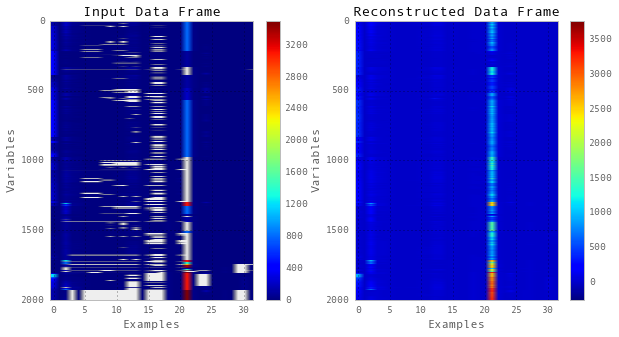

In [123]:
plt.figure(figsize=(10,5))
plt.subplot(121)
visualizeDataFrame(dfo,title='Input Data Frame')
plt.subplot(122)
visualizeDataFrame(reconstructedDF, title='Reconstructed Data Frame')

In [124]:
reconstructedDF.head()

,time_pf_CAT,meiotic_CAT,cell_diameter_um,spindle_length__asters_um,spindle_length_poles_um,spindle_width_um,spindle_aspect_ratio_asters_um,spindle_aspect_ratio_poles_um,astere-to-pole_distance_1_um,aster-to-pole_distance_2_um,...,chromosomes,num_of_cells_CAT,num_of_cells_NUM,classification_CAT,phylum_CAT,organism_CAT,cleavage_type_CAT,fixation_CAT,microscope_CAT,stage_CAT
0,206.968060,0.058192,155.506622,38.854325,26.089388,14.539454,2.872146,1.829866,2.564108,2.700801,...,35.570845,1.544980,0.357124,1.195108,1.221864,1.847314,1.325983,1.360911,2.222022,1.364176
1,216.572695,0.114595,129.533721,25.932133,19.160122,10.494059,2.570200,1.836301,0.350914,0.313799,...,34.633652,1.626936,1.849094,1.177989,1.301692,1.857840,1.185351,1.402422,2.313803,2.126462
2,206.330356,0.170364,170.364567,34.343459,27.062571,14.690534,2.466514,1.847007,0.496482,0.411208,...,35.858018,1.498131,0.431856,1.214488,1.309495,1.791380,1.429292,1.380394,2.401206,2.623684
3,195.900872,0.086600,158.041508,38.869184,35.580738,16.001365,2.617551,2.382955,0.436075,0.334941,...,35.010496,1.523689,0.579972,1.199971,1.324818,1.575194,1.472459,1.395599,2.449604,2.177770
4,205.221477,0.100829,151.391690,37.119537,25.634809,13.686102,2.885605,2.002090,2.064541,2.063196,...,35.573601,1.550674,0.938813,1.127405,1.465354,1.598628,1.386497,1.362987,2.614418,1.944909


In [125]:
dfo.head()

,time_pf_CAT,meiotic_CAT,cell_diameter_um,spindle_length__asters_um,spindle_length_poles_um,spindle_width_um,spindle_aspect_ratio_asters_um,spindle_aspect_ratio_poles_um,astere-to-pole_distance_1_um,aster-to-pole_distance_2_um,...,chromosomes,num_of_cells_CAT,num_of_cells_NUM,classification_CAT,phylum_CAT,organism_CAT,cleavage_type_CAT,fixation_CAT,microscope_CAT,stage_CAT
0,210,0,177.82149,41.37903,26.13072,14.45598,2.862416,1.807606,2.5872,2.9106,...,36,1,1,1,1,1,1,1,1,1
1,210,0,163.05828,24.85329,18.28827,9.97689,2.491086,1.833063,0.0000,0.0000,...,36,1,1,1,1,1,1,1,1,2
2,210,0,206.00580,35.08890,27.24645,14.63385,2.397790,1.861878,0.0000,0.0000,...,36,1,1,1,1,1,1,1,1,3
3,210,0,194.04000,42.39774,42.39774,17.46360,2.427778,2.427778,0.0000,0.0000,...,36,1,1,1,1,1,1,1,1,2
4,210,0,180.36018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,36,1,1,1,1,1,1,1,1,NaN


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11519ec10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x114d87c50>]], dtype=object)

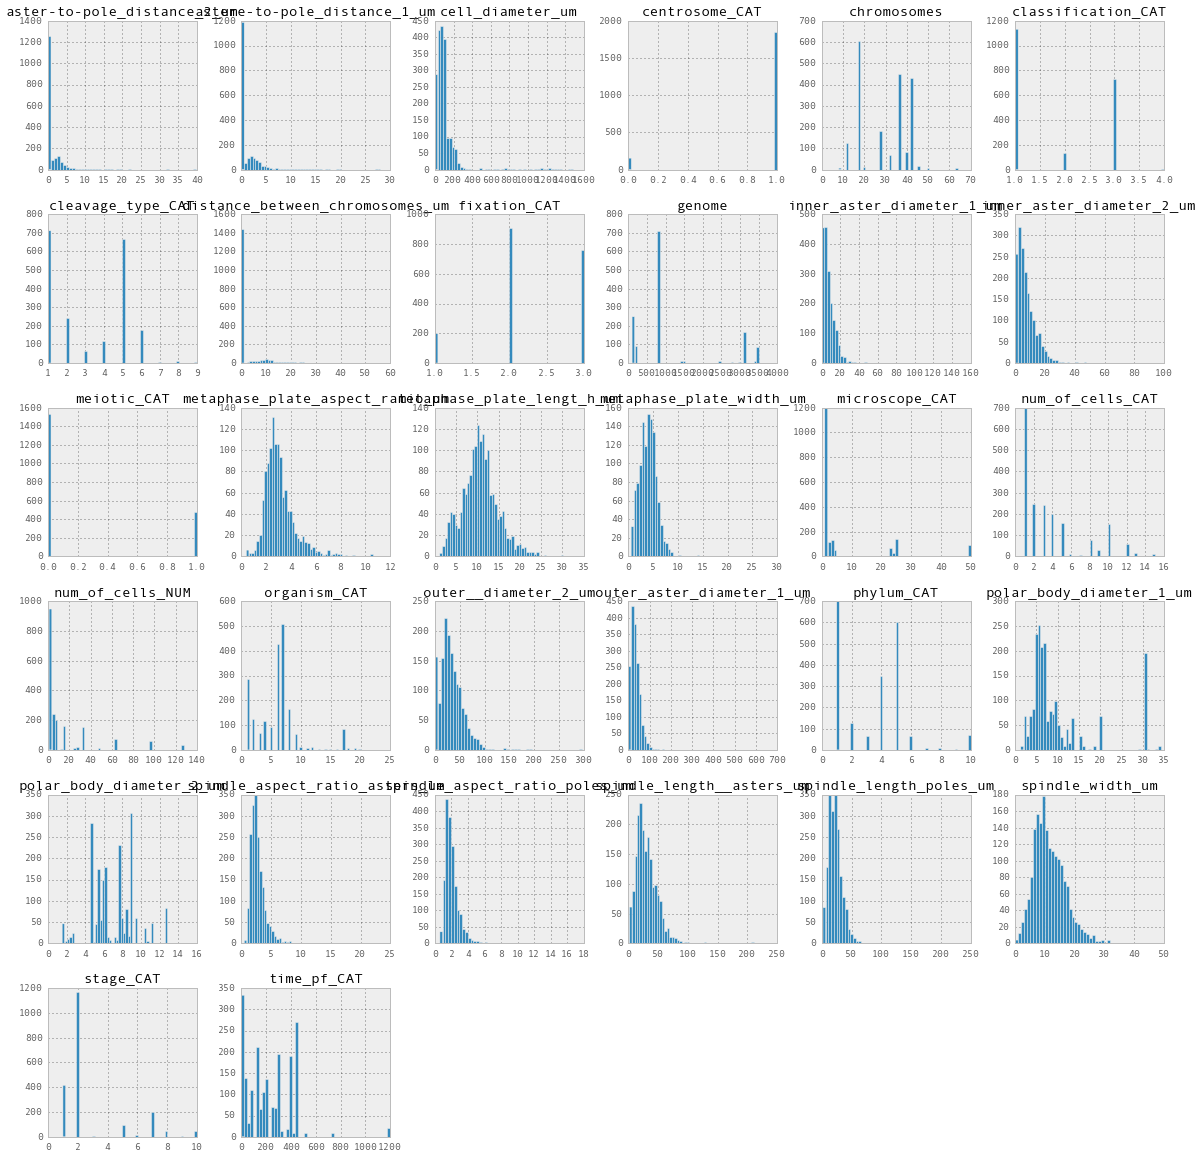

In [126]:
dfo.hist(bins=50, figsize=(20,20))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x114e686d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11e32fc50>]], dtype=object)

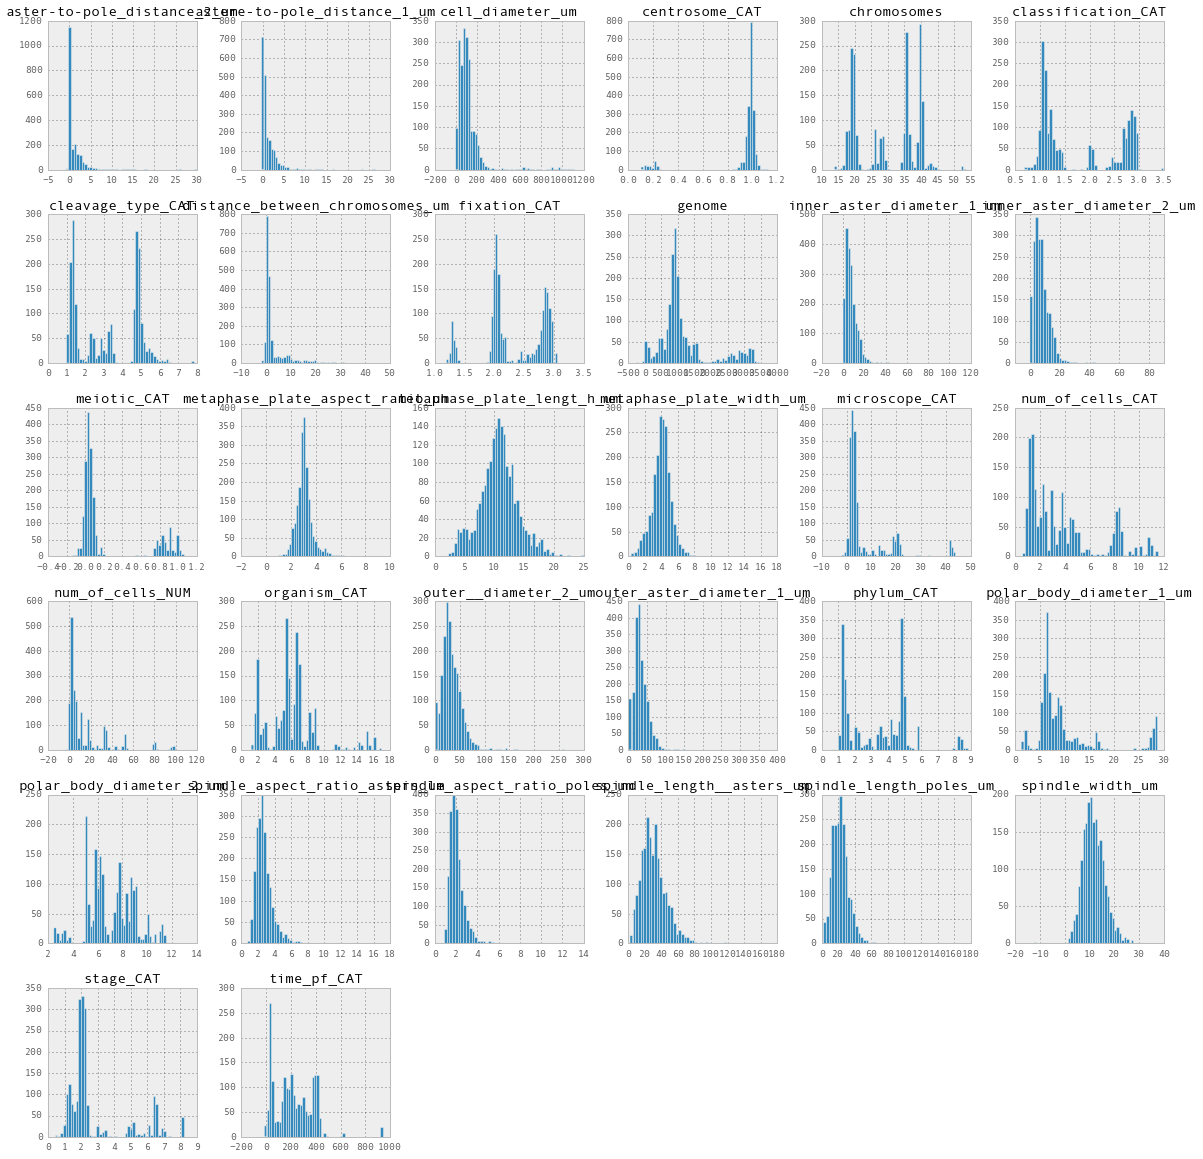

In [127]:
reconstructedDF.hist(bins=50, figsize=(20,20))

## CLUSTERING

In [128]:
cols_CAT=[re.match(r'.*_CAT',name).string for name in dfo.columns if re.match(r'.*_CAT',name)]
dfo_no_CAT=dfo.drop(cols_CAT,axis=1)

In [129]:
dfo_no_CAT.head()

,cell_diameter_um,spindle_length__asters_um,spindle_length_poles_um,spindle_width_um,spindle_aspect_ratio_asters_um,spindle_aspect_ratio_poles_um,astere-to-pole_distance_1_um,aster-to-pole_distance_2_um,inner_aster_diameter_1_um,inner_aster_diameter_2_um,...,outer__diameter_2_um,metaphase_plate_lengt_h_um,metaphase_plate_width_um,metaphase_plate_aspect_ratio_um,polar_body_diameter_1_um,polar_body_diameter_2_um,distance_between_chromosomes_um,genome,chromosomes,num_of_cells_NUM
0,177.82149,41.37903,26.13072,14.45598,2.862416,1.807606,2.5872,2.9106,6.93693,7.40586,...,40.39266,12.61260,NaN,NaN,NaN,NaN,10.55901,811,36,1
1,163.05828,24.85329,18.28827,9.97689,2.491086,1.833063,0.0000,0.0000,6.43566,7.53522,...,37.32036,9.02286,2.40933,3.744966,NaN,NaN,0.00000,811,36,1
2,206.00580,35.08890,27.24645,14.63385,2.397790,1.861878,0.0000,0.0000,6.93693,6.40332,...,39.11523,16.05681,NaN,NaN,8.23053,NaN,NaN,811,36,1
3,194.04000,42.39774,42.39774,17.46360,2.427778,2.427778,0.0000,0.0000,8.35989,9.16839,...,35.71953,7.72926,4.02633,1.919679,8.23053,NaN,0.00000,811,36,1
4,180.36018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,10.33263,10.78539,NaN,811,36,1


In [130]:
dfo_no_CAT_NUM=dfo_no_CAT.drop('num_of_cells_NUM',axis=1)

Using R to run Shapiro test for normality

shapiro.test

Crawley, Michael J. (2012-11-07). The R Book (Kindle Location 12538). Wiley. Kindle Edition.   
http://ipython.org/ipython-doc/2/config/extensions/rmagic.html    
http://docs.ggplot2.org/current/facet_grid.html


In [131]:
%%R -i dfo_no_CAT_NUM
head(dfo_no_CAT_NUM)
shapiro.test(dfo_no_CAT_NUM$cell_diameter_um)


	Shapiro-Wilk normality test

data:  dfo_no_CAT_NUM$cell_diameter_um
W = 0.4412, p-value < 2.2e-16



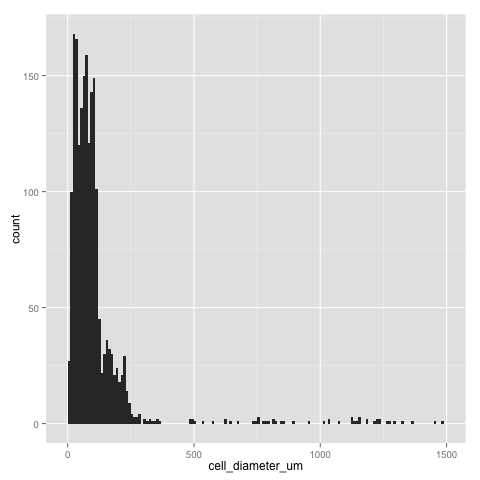

In [132]:
%%R -i dfo_no_CAT_NUM
library(ggplot2)
ggplot(data=dfo_no_CAT_NUM,aes(x=cell_diameter_um))+geom_histogram(binwidth=10)

In [133]:
%%R -i dfo_no_CAT_NUM
library(ggplot2)

# Multiple plot function
#
# ggplot objects can be passed in ..., or to plotlist (as a list of ggplot objects)
# - cols:   Number of columns in layout
# - layout: A matrix specifying the layout. If present, 'cols' is ignored.
#
# If the layout is something like matrix(c(1,2,3,3), nrow=2, byrow=TRUE),
# then plot 1 will go in the upper left, 2 will go in the upper right, and
# 3 will go all the way across the bottom.
#
multiplot <- function(..., plotlist=NULL, file, cols=1, layout=NULL) {
  require(grid)

  # Make a list from the ... arguments and plotlist
  plots <- c(list(...), plotlist)

  numPlots = length(plots)

  # If layout is NULL, then use 'cols' to determine layout
  if (is.null(layout)) {
    # Make the panel
    # ncol: Number of columns of plots
    # nrow: Number of rows needed, calculated from # of cols
    layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                    ncol = cols, nrow = ceiling(numPlots/cols))
  }

 if (numPlots==1) {
    print(plots[[1]])

  } else {
    # Set up the page
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

    # Make each plot, in the correct location
    for (i in 1:numPlots) {
      # Get the i,j matrix positions of the regions that contain this subplot
      matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

      print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                      layout.pos.col = matchidx$col))
    }
  }
}

plot_list=list()
for (i in 1:length(dfo_no_CAT_NUM)){
        #print(mean(dfo_no_CAT_NUM[,i],na.rm=TRUE))
        plot_list[[i]]<-ggplot(data=dfo_no_CAT_NUM,aes(x=dfo_no_CAT_NUM[,i]))+geom_histogram(binwidth=10)
}


#for 
#ggplot(data=dfo_no_CAT_NUM)

In [134]:
#FINISH HERE: SHAPIRO IN R
#SHAPIRO on GROUPBY

### KMeans

KMeans is a spatial 

In [135]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale

In [136]:
#from sklearn.datasets import load_digits

In [137]:
#digits = load_digits()

In [138]:
#type(digits)

In [139]:
#digits.keys()

In [140]:
#digits['data']


In [141]:
#?np.vstack
#?np.random.multivariate_normal

http://stats.stackexchange.com/questions/21222/are-mean-normalization-and-feature-scaling-needed-for-k-means-clustering   
*If your variables are of incomparable units (e.g. height in cm and weight in kg) then you should standardize variables, of course. Even if variables are of the same units but show **quite different variances** it is still a good idea to standardize before K-means. You see, **K-means clustering is "isotropic" in all directions of space** and therefore tends to produce more or less round (rather than elongated) clusters. In this situation leaving variances unequal is equivalent to putting more weight on variables with smaller variance, so clusters will tend to be separated along variables with greater variance. A different thing also worth to remind is that K-means clustering results are sensitive to the **order of objects** in the data set. A justified practice would be to run the analysis several times, randomizing objects order; then average the cluster centres of those runs and input the centres as initial ones for one final run of the analysis.*


In [142]:
reconstructed.shape

(2001, 32)

In [143]:
reconstructed #scaled

array([[  2.06968060e+02,   5.81915105e-02,   1.55506622e+02, ...,
          1.36091082e+00,   2.22202198e+00,   1.36417573e+00],
       [  2.16572695e+02,   1.14595288e-01,   1.29533721e+02, ...,
          1.40242181e+00,   2.31380252e+00,   2.12646231e+00],
       [  2.06330356e+02,   1.70363886e-01,   1.70364567e+02, ...,
          1.38039407e+00,   2.40120643e+00,   2.62368361e+00],
       ..., 
       [  1.24972731e+02,   1.88528269e-01,   9.28786964e+01, ...,
          2.55530701e+00,   1.39633183e+01,   1.77263689e+00],
       [  1.23800738e+02,   1.85954104e-01,   9.37196949e+01, ...,
          2.55152978e+00,   1.40129199e+01,   1.77219249e+00],
       [  1.24197498e+02,   1.87099663e-01,   9.45674983e+01, ...,
          2.55386430e+00,   1.39916079e+01,   1.77224885e+00]])

In [144]:
reconstructedDF_scaled=scale(reconstructedDF.values)

In [145]:
reconstructedDF.columns

Index([u'time_pf_CAT', u'meiotic_CAT', u'cell_diameter_um', u'spindle_length__asters_um', u'spindle_length_poles_um', u'spindle_width_um', u'spindle_aspect_ratio_asters_um', u'spindle_aspect_ratio_poles_um', u'astere-to-pole_distance_1_um', u'aster-to-pole_distance_2_um', u'inner_aster_diameter_1_um', u'inner_aster_diameter_2_um', u'outer_aster_diameter_1_um', u'outer__diameter_2_um', u'centrosome_CAT', u'metaphase_plate_lengt_h_um', u'metaphase_plate_width_um', u'metaphase_plate_aspect_ratio_um', u'polar_body_diameter_1_um', u'polar_body_diameter_2_um', u'distance_between_chromosomes_um', u'genome', u'chromosomes', u'num_of_cells_CAT', u'num_of_cells_NUM', u'classification_CAT', u'phylum_CAT', u'organism_CAT', u'cleavage_type_CAT', u'fixation_CAT', u'microscope_CAT', u'stage_CAT'], dtype='object')

#### ATTEMPT1: simple call

This is a first attempt at clustering.   
To do:  
1. Remove: _CAT columns, time_pf, meiotic, centrosome
2. Fine tune parameters

In [146]:
km1 = KMeans(n_clusters=2,  init='random', n_init=1 , max_iter = 1, random_state=1)

In [147]:
km1.fit(reconstructedDF_scaled)

KMeans(copy_x=True, init='random', max_iter=1, n_clusters=2, n_init=1,
    n_jobs=1, precompute_distances=True, random_state=1, tol=0.0001,
    verbose=0)

In [148]:
centroids1=km1.cluster_centers_

In [149]:
centroids1

array([[-0.39310917,  0.22209135,  0.22457065,  0.34995082,  0.37361078,
         0.33116783,  0.1734107 ,  0.15050015,  0.15429182,  0.1473255 ,
         0.22269707,  0.24646867,  0.21669834,  0.25449797, -0.1045949 ,
         0.31602771,  0.30071179, -0.02618266,  0.17728191,  0.32487411,
         0.04907095,  0.16751523, -0.16743827, -0.3755117 , -0.29250566,
         0.21123148,  0.27701467,  0.0921679 ,  0.29461975, -0.39491292,
         0.19102376,  0.20837015],
       [ 1.00406925, -0.56725997, -0.57359254, -0.8938353 , -0.95426695,
        -0.8458603 , -0.44292112, -0.38440358, -0.39408816, -0.37629498,
        -0.56880707, -0.62952389, -0.55348528, -0.65003211,  0.26715358,
        -0.80718978, -0.76807024,  0.06687508, -0.45280886, -0.82978503,
        -0.12533576, -0.42786305,  0.42766648,  0.95912224,  0.74711038,
        -0.53952197, -0.70754368, -0.23541286, -0.75251013,  1.00867634,
        -0.48790793, -0.53221363]])

In [150]:
y_allocation=km1.predict(reconstructedDF_scaled)

In [151]:
y_allocation[y_allocation==0].shape

(1327,)

In [152]:
y_allocation[y_allocation==1].shape

(674,)

In [153]:
y_allocation=np.reshape(y_allocation,(y_allocation.shape[0],1))

In [154]:
y_allocation.shape

(2001, 1)

*Post-process the data: add categorical columns, add prediction Y column.*

*1. Add prediction column.*

In [155]:
reconstructed_km1=np.hstack((reconstructed,y_allocation))

In [156]:
reconstructed_km1.shape

(2001, 33)

*2. Append to the CAT data frame to allow for contingency testing.*

In [157]:
import re

In [158]:
cols_CAT=[re.match(r'.*_CAT',name).string for name in dfo.columns if re.match(r'.*_CAT',name)]

In [159]:
dfo_CAT_vars=dfo[[re.match(r'.*_CAT',name).string for name in dfo.columns if re.match(r'.*_CAT',name)]].values

In [160]:
#this is the data frame to use in the later examples too
dfo_CAT_vars.shape

(2001, 11)

In [161]:
dfo_CAT_vars_km1=np.hstack((dfo_CAT_vars,y_allocation))

In [162]:
dfo_CAT_vars_km1.shape

(2001, 12)

In [163]:
cols_CAT.append('km1')

In [164]:
cols_CAT

['time_pf_CAT',
 'meiotic_CAT',
 'centrosome_CAT',
 'num_of_cells_CAT',
 'classification_CAT',
 'phylum_CAT',
 'organism_CAT',
 'cleavage_type_CAT',
 'fixation_CAT',
 'microscope_CAT',
 'stage_CAT',
 'km1']

In [165]:
dfo_CAT_vars_km1_DF=pd.DataFrame(dfo_CAT_vars_km1,columns=cols_CAT)

In [166]:
dfo_CAT_vars_km1_DF.head()

,time_pf_CAT,meiotic_CAT,centrosome_CAT,num_of_cells_CAT,classification_CAT,phylum_CAT,organism_CAT,cleavage_type_CAT,fixation_CAT,microscope_CAT,stage_CAT,km1
0,210,0,1,1,1,1,1,1,1,1,1,0
1,210,0,1,1,1,1,1,1,1,1,2,0
2,210,0,1,1,1,1,1,1,1,1,3,0
3,210,0,1,1,1,1,1,1,1,1,2,0
4,210,0,1,1,1,1,1,1,1,1,NaN,0


*Create contingency table:*

In [167]:
dfo_CAT_vars_km1_DF.meiotic_CAT.value_counts()

0    1528
1     473
dtype: int64

In [168]:
dfo_CAT_vars_km1_DF.groupby(['meiotic_CAT','km1']).count().iloc[:,1]

meiotic_CAT  km1
0            0      886
             1      642
1            0      441
             1       32
Name: centrosome_CAT, dtype: int64

In [169]:
type(dfo_CAT_vars_km1_DF.groupby(['meiotic_CAT','km1']).count().iloc[:,1])

pandas.core.series.Series

In [170]:
unstacked_meiotic_km1=dfo_CAT_vars_km1_DF.groupby(['meiotic_CAT','km1']).count().iloc[:,1].unstack()

In [171]:
unstacked_meiotic_km1.shape

(2, 2)

In [172]:
unstacked_meiotic_km1

km1,0.0,1.0
meiotic_CAT,,
0,886,642
1,441,32


*Running statistics on re-destributed data*

In [173]:
#http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.fisher_exact.html
#http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.chi2_contingency.html#scipy.stats.chi2_contingency

In [174]:
from scipy.stats import chisquare,fisher_exact

In [175]:
chisquare([886,642,441,32],[764,764,237,236])

(390.89727054504851, 2.0740268451248341e-84)

In [176]:
obs = np.array([[16, 18, 16, 14, 12, 12], [32, 24, 16, 28, 20, 24]]).T

In [177]:
fisher_exact(unstacked_meiotic_km1.values)

(0.10014057544097597, 1.4349195395173389e-54)

*Let's try some R Magic*

http://ipython.org/ipython-doc/2/config/extensions/rmagic.html  
http://nbviewer.ipython.org/github/fperez/nipy-notebooks/blob/master/exploring_r_formula.ipynb

In [178]:
import rpy2

In [179]:
%load_ext rmagic

The rmagic extension is already loaded. To reload it, use:
  %reload_ext rmagic


Check out:
8.8.3 Unequal probabilities in the null hypothesis    

Crawley, Michael J. (2012-11-07). The R Book (Kindle Location 13441). Wiley. Kindle Edition.    
location: 13435

In [180]:
%%R
chisq.test(c(886,642,441,32),p=c(0.38,0.38,0.12,0.12))


	Chi-squared test for given probabilities

data:  c(886, 642, 441, 32)
X-squared = 387.6204, df = 3, p-value < 2.2e-16



##### *ATTEMPT1b: simple but with columns left out: drop all CATs*

TO-DO: wrap preprocessing into function: (1) which columns to drop, (2) then: run scaling
        

Drop: 

In [181]:
reconstructedDF.head()

,time_pf_CAT,meiotic_CAT,cell_diameter_um,spindle_length__asters_um,spindle_length_poles_um,spindle_width_um,spindle_aspect_ratio_asters_um,spindle_aspect_ratio_poles_um,astere-to-pole_distance_1_um,aster-to-pole_distance_2_um,...,chromosomes,num_of_cells_CAT,num_of_cells_NUM,classification_CAT,phylum_CAT,organism_CAT,cleavage_type_CAT,fixation_CAT,microscope_CAT,stage_CAT
0,206.968060,0.058192,155.506622,38.854325,26.089388,14.539454,2.872146,1.829866,2.564108,2.700801,...,35.570845,1.544980,0.357124,1.195108,1.221864,1.847314,1.325983,1.360911,2.222022,1.364176
1,216.572695,0.114595,129.533721,25.932133,19.160122,10.494059,2.570200,1.836301,0.350914,0.313799,...,34.633652,1.626936,1.849094,1.177989,1.301692,1.857840,1.185351,1.402422,2.313803,2.126462
2,206.330356,0.170364,170.364567,34.343459,27.062571,14.690534,2.466514,1.847007,0.496482,0.411208,...,35.858018,1.498131,0.431856,1.214488,1.309495,1.791380,1.429292,1.380394,2.401206,2.623684
3,195.900872,0.086600,158.041508,38.869184,35.580738,16.001365,2.617551,2.382955,0.436075,0.334941,...,35.010496,1.523689,0.579972,1.199971,1.324818,1.575194,1.472459,1.395599,2.449604,2.177770
4,205.221477,0.100829,151.391690,37.119537,25.634809,13.686102,2.885605,2.002090,2.064541,2.063196,...,35.573601,1.550674,0.938813,1.127405,1.465354,1.598628,1.386497,1.362987,2.614418,1.944909


In [182]:
cols_CAT

['time_pf_CAT',
 'meiotic_CAT',
 'centrosome_CAT',
 'num_of_cells_CAT',
 'classification_CAT',
 'phylum_CAT',
 'organism_CAT',
 'cleavage_type_CAT',
 'fixation_CAT',
 'microscope_CAT',
 'stage_CAT',
 'km1']

In [183]:
cols_CAT.pop()
cols_CAT

['time_pf_CAT',
 'meiotic_CAT',
 'centrosome_CAT',
 'num_of_cells_CAT',
 'classification_CAT',
 'phylum_CAT',
 'organism_CAT',
 'cleavage_type_CAT',
 'fixation_CAT',
 'microscope_CAT',
 'stage_CAT']

In [184]:
#reconstructedDF_scaled.head()
reconstructedDF_no_CAT=reconstructedDF.drop(cols_CAT,axis=1)

In [185]:
reconstructedDF_no_CAT.head()

,cell_diameter_um,spindle_length__asters_um,spindle_length_poles_um,spindle_width_um,spindle_aspect_ratio_asters_um,spindle_aspect_ratio_poles_um,astere-to-pole_distance_1_um,aster-to-pole_distance_2_um,inner_aster_diameter_1_um,inner_aster_diameter_2_um,...,outer__diameter_2_um,metaphase_plate_lengt_h_um,metaphase_plate_width_um,metaphase_plate_aspect_ratio_um,polar_body_diameter_1_um,polar_body_diameter_2_um,distance_between_chromosomes_um,genome,chromosomes,num_of_cells_NUM
0,155.506622,38.854325,26.089388,14.539454,2.872146,1.829866,2.564108,2.700801,8.065905,8.590724,...,40.171705,12.028723,4.378775,3.321839,4.417804,7.808377,8.825499,844.672079,35.570845,0.357124
1,129.533721,25.932133,19.160122,10.494059,2.570200,1.836301,0.350914,0.313799,7.207820,7.206433,...,33.171043,9.612330,2.814890,3.619218,4.267515,7.446829,1.149978,675.917697,34.633652,1.849094
2,170.364567,34.343459,27.062571,14.690534,2.466514,1.847007,0.496482,0.411208,7.624172,7.919827,...,37.405432,14.267282,4.584083,3.461178,6.695269,8.242051,1.479178,1074.562031,35.858018,0.431856
3,158.041508,38.869184,35.580738,16.001365,2.617551,2.382955,0.436075,0.334941,9.037917,8.897177,...,39.066497,9.492081,4.347267,2.329873,7.111405,8.536231,2.173995,888.555103,35.010496,0.579972
4,151.391690,37.119537,25.634809,13.686102,2.885605,2.002090,2.064541,2.063196,10.109383,10.061447,...,39.999252,11.789215,4.382029,3.075484,8.718926,10.106963,3.870152,929.808071,35.573601,0.938813


In [186]:
reconstructedDF_no_CAT=reconstructedDF_no_CAT.drop('num_of_cells_NUM',axis=1)

In [187]:
reconstructedDF_no_CAT.head()

,cell_diameter_um,spindle_length__asters_um,spindle_length_poles_um,spindle_width_um,spindle_aspect_ratio_asters_um,spindle_aspect_ratio_poles_um,astere-to-pole_distance_1_um,aster-to-pole_distance_2_um,inner_aster_diameter_1_um,inner_aster_diameter_2_um,outer_aster_diameter_1_um,outer__diameter_2_um,metaphase_plate_lengt_h_um,metaphase_plate_width_um,metaphase_plate_aspect_ratio_um,polar_body_diameter_1_um,polar_body_diameter_2_um,distance_between_chromosomes_um,genome,chromosomes
0,155.506622,38.854325,26.089388,14.539454,2.872146,1.829866,2.564108,2.700801,8.065905,8.590724,41.643155,40.171705,12.028723,4.378775,3.321839,4.417804,7.808377,8.825499,844.672079,35.570845
1,129.533721,25.932133,19.160122,10.494059,2.570200,1.836301,0.350914,0.313799,7.207820,7.206433,34.158278,33.171043,9.612330,2.814890,3.619218,4.267515,7.446829,1.149978,675.917697,34.633652
2,170.364567,34.343459,27.062571,14.690534,2.466514,1.847007,0.496482,0.411208,7.624172,7.919827,44.602611,37.405432,14.267282,4.584083,3.461178,6.695269,8.242051,1.479178,1074.562031,35.858018
3,158.041508,38.869184,35.580738,16.001365,2.617551,2.382955,0.436075,0.334941,9.037917,8.897177,40.991591,39.066497,9.492081,4.347267,2.329873,7.111405,8.536231,2.173995,888.555103,35.010496
4,151.391690,37.119537,25.634809,13.686102,2.885605,2.002090,2.064541,2.063196,10.109383,10.061447,40.300208,39.999252,11.789215,4.382029,3.075484,8.718926,10.106963,3.870152,929.808071,35.573601


In [188]:
km1b = KMeans(n_clusters=2,  init='random', n_init=1 , max_iter = 1, random_state=1)

In [189]:
reconstructedDF_no_CAT_scaled=scale(reconstructedDF_no_CAT.values)

In [190]:
km1b.fit(reconstructedDF_no_CAT_scaled)

KMeans(copy_x=True, init='random', max_iter=1, n_clusters=2, n_init=1,
    n_jobs=1, precompute_distances=True, random_state=1, tol=0.0001,
    verbose=0)

*Let's compare the previous simple example with the current, "dropped all CATs" simple run.*

In [191]:
km1b.cluster_centers_

array([[ 0.18045341,  0.37036779,  0.37609747,  0.31971084,  0.2103869 ,
         0.17800819,  0.17804429,  0.16933598,  0.24984322,  0.27704082,
         0.25762616,  0.2886929 ,  0.35765478,  0.33847335, -0.02010732,
         0.23245717,  0.31895786,  0.03046216,  0.21393766, -0.11319899],
       [-0.4736902 , -0.97221545, -0.98725587, -0.83924096, -0.55226561,
        -0.4672715 , -0.46736625, -0.44450695, -0.65583846, -0.72723216,
        -0.67626866, -0.75781887, -0.93884381, -0.88849253,  0.0527817 ,
        -0.61020006, -0.83726438, -0.07996316, -0.56158636,  0.29714735]])

In [192]:
km1.cluster_centers_

array([[-0.39310917,  0.22209135,  0.22457065,  0.34995082,  0.37361078,
         0.33116783,  0.1734107 ,  0.15050015,  0.15429182,  0.1473255 ,
         0.22269707,  0.24646867,  0.21669834,  0.25449797, -0.1045949 ,
         0.31602771,  0.30071179, -0.02618266,  0.17728191,  0.32487411,
         0.04907095,  0.16751523, -0.16743827, -0.3755117 , -0.29250566,
         0.21123148,  0.27701467,  0.0921679 ,  0.29461975, -0.39491292,
         0.19102376,  0.20837015],
       [ 1.00406925, -0.56725997, -0.57359254, -0.8938353 , -0.95426695,
        -0.8458603 , -0.44292112, -0.38440358, -0.39408816, -0.37629498,
        -0.56880707, -0.62952389, -0.55348528, -0.65003211,  0.26715358,
        -0.80718978, -0.76807024,  0.06687508, -0.45280886, -0.82978503,
        -0.12533576, -0.42786305,  0.42766648,  0.95912224,  0.74711038,
        -0.53952197, -0.70754368, -0.23541286, -0.75251013,  1.00867634,
        -0.48790793, -0.53221363]])

In [193]:
y_allocation_1b=km1b.predict(reconstructedDF_no_CAT_scaled)

In [194]:
np.reshape(y_allocation,(y_allocation_1b.shape))

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [195]:
y_allocation.shape

(2001, 1)

In [196]:
y_allocation_1b.shape

(2001,)

In [197]:
np.sum(y_allocation_1b)

740

In [198]:
np.sum(y_allocation)

674

*The fraction of identical assignments:*

In [199]:
len([i for i,j in zip(np.reshape(y_allocation,(y_allocation_1b.shape)).tolist(),y_allocation_1b.tolist()) if i==j])/2001.0

0.8850574712643678

In [200]:
indices_in_common=[]
counter =0
for i, j in zip(np.reshape(y_allocation,(y_allocation_1b.shape)).tolist(),y_allocation_1b.tolist()):
    if i==j:
        indices_in_common.append(counter)
    counter += 1

In [201]:
#indices

In [202]:
reconstructedDF_no_CAT_km1b=np.hstack((reconstructedDF_no_CAT,np.reshape(y_allocation_1b,(len(y_allocation_1b),1))))

In [203]:
reconstructedDF_no_CAT_km1b.shape

(2001, 21)

In [204]:
reconstructedDF_no_CAT.shape

(2001, 20)

In [205]:
dfo_CAT_vars.shape

(2001, 11)

In [206]:
dfo_CAT_vars_km1b=np.hstack((dfo_CAT_vars,np.reshape(y_allocation_1b,(len(y_allocation_1b),1))))

In [207]:
dfo_CAT_vars_km1b.shape

(2001, 12)

In [208]:
cols_CAT_km1b=cols_CAT.append('km1b')
dfo_CAT_vars_km1b_DF=pd.DataFrame(dfo_CAT_vars_km1b,columns=cols_CAT)

In [209]:
dfo_CAT_vars_km1b_DF.head()

,time_pf_CAT,meiotic_CAT,centrosome_CAT,num_of_cells_CAT,classification_CAT,phylum_CAT,organism_CAT,cleavage_type_CAT,fixation_CAT,microscope_CAT,stage_CAT,km1b
0,210,0,1,1,1,1,1,1,1,1,1,0
1,210,0,1,1,1,1,1,1,1,1,2,1
2,210,0,1,1,1,1,1,1,1,1,3,0
3,210,0,1,1,1,1,1,1,1,1,2,0
4,210,0,1,1,1,1,1,1,1,1,NaN,0


In [210]:
unstacked_meiotic_km1b=dfo_CAT_vars_km1b_DF.groupby(['meiotic_CAT','km1b']).count().iloc[:,1].unstack()

In [211]:
unstacked_meiotic_km1b

km1b,0.0,1.0
meiotic_CAT,,
0,952,576
1,309,164


*Determine expected counts:*

In [212]:
unstacked_meiotic_km1b.index.names

FrozenList([u'meiotic_CAT'])

In [213]:
unstacked_meiotic_km1b.columns.names

FrozenList([u'km1b'])

In [214]:
unstacked_meiotic_km1b.columns

Float64Index([0.0, 1.0], dtype='float64')

In [215]:
print 'meiotic: ', unstacked_meiotic_km1b.loc[1,].sum()
print 'mitotic: ', unstacked_meiotic_km1b.loc[0,].sum()
print 'total: ', unstacked_meiotic_km1b.loc[1,].sum()+unstacked_meiotic_km1b.loc[0,].sum()

meiotic:  473
mitotic:  1528
total:  2001


In [216]:
print 'meiotic: ', unstacked_meiotic_km1b.loc[1,].sum()/2.0
print 'mitotic: ', unstacked_meiotic_km1b.loc[0,].sum()/2.0

meiotic:  236.5
mitotic:  764.0


In [217]:
#expected probabilities
print 'meiotic: ', (unstacked_meiotic_km1b.loc[1,].sum()/2.0)/2001
print 'mitotic: ', (unstacked_meiotic_km1b.loc[0,].sum()/2.0)/2001


meiotic:  0.118190904548
mitotic:  0.381809095452


In [218]:
unstacked_meiotic_km1b.unstack()
observed_counts=unstacked_meiotic_km1b.unstack()
expected_probs=[(unstacked_meiotic_km1b.loc[1,].sum()/2.0)/2001,(unstacked_meiotic_km1b.loc[0,].sum()/2.0)/2001,(unstacked_meiotic_km1b.loc[1,].sum()/2.0)/2001,(unstacked_meiotic_km1b.loc[0,].sum()/2.0)/2001]
observed_counts,expected_probs

(km1b  meiotic_CAT
 0     0              952
       1              309
 1     0              576
       1              164
 dtype: int64,
 [0.11819090454772614,
  0.38180909545227387,
  0.11819090454772614,
  0.38180909545227387])

*Pass values to R:*

In [219]:
%%R -i observed_counts,expected_probs
chisq.test(observed_counts,p=expected_probs)


	Chi-squared test for given probabilities

data:  observed_counts
X-squared = 3394.19, df = 3, p-value < 2.2e-16



In [220]:
%%R
chisq.test(c(952,576,309,164),p=c(0.38,0.38,0.12,0.12))


	Chi-squared test for given probabilities

data:  c(952, 576, 309, 164)
X-squared = 136.8879, df = 3, p-value < 2.2e-16



In [221]:
dfo_CAT_vars_km1b_DF.groupby(['centrosome_CAT','km1b']).count().iloc[:,1].unstack()

km1b,0.0,1.0
centrosome_CAT,,
0,89,65
1,1172,675


In [222]:
#pd.DataFrame(reconstructedDF_no_CAT_km1b).iloc[:,20]==0
reconstructedDF_no_CAT_km1b_DF=pd.DataFrame(reconstructedDF_no_CAT_km1b)

In [223]:
len(reconstructedDF_no_CAT_km1b_DF[reconstructedDF_no_CAT_km1b_DF[20]==0][0].tolist())
len(reconstructedDF_no_CAT_km1b_DF[reconstructedDF_no_CAT_km1b_DF[20]==1][0].tolist())

740

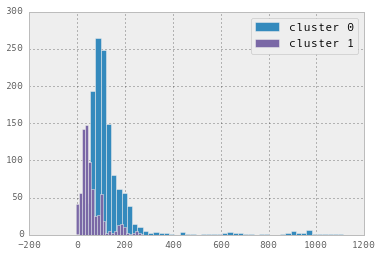

In [224]:
#http://stackoverflow.com/questions/6871201/plot-two-histograms-at-the-same-time-with-matplotlib
#bins=np.linspace(min(reconstructedDF_no_CAT_km1b_DF[0]),max(reconstructedDF_no_CAT_km1b_DF),50)
plt.hist(reconstructedDF_no_CAT_km1b_DF[reconstructedDF_no_CAT_km1b_DF[20]==0][0].tolist(),bins=50,label='cluster 0')
plt.hist(reconstructedDF_no_CAT_km1b_DF[reconstructedDF_no_CAT_km1b_DF[20]==1][0].tolist(),bins=50,label='cluster 1')
plt.legend(loc='upper right')
#k=reconstructedDF_no_CAT_km1b_DF[reconstructedDF_no_CAT_km1b_DF[20]==1][0]

In [225]:
def two_var_hist(data_frame):
    for col in data_frame.columns:
        plt.hist
    return plot

array([<matplotlib.axes._subplots.AxesSubplot object at 0x122688050>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x122aa5910>], dtype=object)

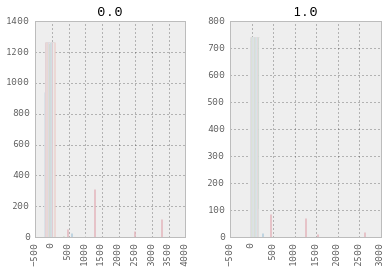

In [226]:
reconstructedDF_no_CAT_km1b_DF.hist(by=reconstructedDF_no_CAT_km1b_DF[20])
#reconstructedDF_no_CAT_km1b_DF[reconstructedDF_no_CAT_km1b_DF[20]==0].hist()
#reconstructedDF_no_CAT_km1b_DF[reconstructedDF_no_CAT_km1b_DF[20]==1].hist()

In [227]:
reconstructedDF_no_CAT_km1b_DF.hist[20]

TypeError: 'instancemethod' object has no attribute '__getitem__'